# ANALYSIS OF CONTROL DATASETS TO SEE REPEATABILITY AND REPRODUCIBILITY IN OUR RESULTS AND FINDINGS

In [1]:
# Libraries
import seaborn as sns
import numpy as np
from pathlib import Path
import sys
import pandas as pd

# Add /Source to sys.path if not already present
project_root = Path.cwd().parent
source_path = project_root / "src"

if source_path.exists() and str(source_path) not in sys.path:
    sys.path.insert(0, str(source_path))

# Utility functions
from calcium_activity_characterization.analysis.visualizers import (
    plot_violin,
    plot_points_mean_std,
    visualize_image,
    plot_scatter_size_coded,
    plot_histogram,
    plot_histogram_by_group,
    plot_pie_chart,
    plot_bar,
    plot_xy_with_regression,
    plot_heatmap
    )
from calcium_activity_characterization.io.csv_loader import load_dataset
from calcium_activity_characterization.analysis.statistics import (
    analyze_peak_intervals,
    build_neighbor_pair_stats
)

sns.set(style="whitegrid")

# Define paths to control datasets
path = "D:/Mateo/Results"

# Load and merge datasets
peaks = load_dataset(path=path, file_name="merged_peaks.csv")
cells = load_dataset(path=path, file_name="merged_cells.csv")
events = load_dataset(path=path, file_name="merged_events.csv")
communications = load_dataset(path=path, file_name="merged_communications.csv")
experiments = load_dataset(path=path, file_name="experiments.csv")

c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\io\csv_loader.py:33: DtypeWarning: Columns (29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(f"{path}/{file_name}")
c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\io\csv_loader.py:33: DtypeWarning: Columns (32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(f"{path}/{file_name}")
c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\io\csv_loader.py:33: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(f"{path}/{file_name}")


## Define control datasets
> All image sequences that are first run, spontaneous and have more than 900 cells in the FoV.

In [2]:
event_counts_wide = (
    events.groupby(["dataset", "Event type"])
          .size()                           # same as counting rows of Event ID
          .unstack("Event type", fill_value=0)
)

# Ensure all three columns exist even if absent in data
for col in ["GlobalEvent", "SequentialEvent"]:
    if col not in event_counts_wide.columns:
        event_counts_wide[col] = 0

# Order columns and reset index for merge
event_counts_wide = event_counts_wide[["GlobalEvent", "SequentialEvent"]].reset_index()

# Merge into experiments and fill missing with 0
experiments = experiments.merge(event_counts_wide, on="dataset", how="left")

for col in ["GlobalEvent", "SequentialEvent"]:
    experiments[col] = experiments[col].fillna(0).astype(int)

# Count "individual" peaks per dataset
individual_counts = (
    peaks.loc[peaks["In event"].str.lower() == "individual", ["dataset"]]
         .groupby("dataset")
         .size()
         .reset_index(name="IndividualEvent")
)

# Merge into experiments and fill missing with 0
experiments = experiments.merge(
    individual_counts, on="dataset", how="left"
)
experiments["IndividualEvent"] = (
    experiments["IndividualEvent"].fillna(0).astype(int)
)

In [3]:
cells_counts = cells.groupby("dataset")["Cell ID"].count()
experiments["Number of cells"] = experiments["dataset"].map(cells_counts)

control_experiments = experiments[(experiments["condition"] == "control - 1st run") &
                                  (experiments["Number of cells"] > 900)].copy()

display(experiments)

control_peaks = peaks[peaks["dataset"].isin(control_experiments["dataset"])].copy()
control_cells = cells[cells["dataset"].isin(control_experiments["dataset"])].copy()
control_events = events[events["dataset"].isin(control_experiments["dataset"])].copy()
control_communications = communications[communications["dataset"].isin(control_experiments["dataset"])].copy()

path      date image_sequence experiment_type  \
0   D:/Mateo/20250326/Output/IS1  20250326            IS1     spontaneous   
1   D:/Mateo/20250326/Output/IS2  20250326            IS2     spontaneous   
2   D:/Mateo/20250326/Output/IS3  20250326            IS3     spontaneous   
3   D:/Mateo/20250326/Output/IS4  20250326            IS4     spontaneous   
4   D:/Mateo/20250404/Output/IS1  20250404            IS1     spontaneous   
..                           ...       ...            ...             ...   
72  D:/Mateo/20250810/Output/IS2  20250810            IS2     spontaneous   
73  D:/Mateo/20250810/Output/IS3  20250810            IS3      stimulated   
74  D:/Mateo/20250810/Output/IS4  20250810            IS4      stimulated   
75  D:/Mateo/20250810/Output/IS5  20250810            IS5      stimulated   
76  D:/Mateo/20250810/Output/IS6  20250810            IS6      stimulated   

            condition  confluency concentration time       dataset  \
0   control - 1st run     1200000           NaN  NaN  20250326_IS1   
1   control - 2nd run     1200000           NaN  NaN  20250326_IS2   
2   control - 1st run     1200000           NaN  NaN  20250326_IS3   
3   control - 2nd run     1200000           NaN  NaN  20250326_IS4   
4   control - 1st run     1200000           NaN  NaN  20250404_IS1   
..                ...         ...           ...  ...           ...   
72  control - 1st run     1200000           NaN  NaN  20250810_IS2   
73    light - 1st run     1200000           NaN  300  20250810_IS3   
74    light - 1st run     1200000           NaN  300  20250810_IS4   
75    light - 1st run     1200000           NaN  600  20250810_IS5   
76    light - 1st run     1200000           NaN  600  20250810_IS6   

    GlobalEvent  SequentialEvent  IndividualEvent  Number of cells  
0             5             1167              834             1074  
1             0              431              853              837  
2             4             1263              890              985  
3             0             1221             1968              969  
4             5              869              772             1234  
..          ...              ...              ...              ...  
72            2              729             1183              769  
73            3              272              606             1008  
74            1              969             1206              924  
75            1             1179             1427             1098  
76            1              841             1241              962  

[77 rows x 13 columns]

## GLOBAL EVENTS ANALYSIS

[2025-08-16 17:54:15] [INFO] calcium: plot_violin: removed 56 outliers out of 27502 on 'Duration (s)' (lower=-104, upper=222)


c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:954: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(**violin_kwargs)
c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:984: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp_ax = sns.boxplot(


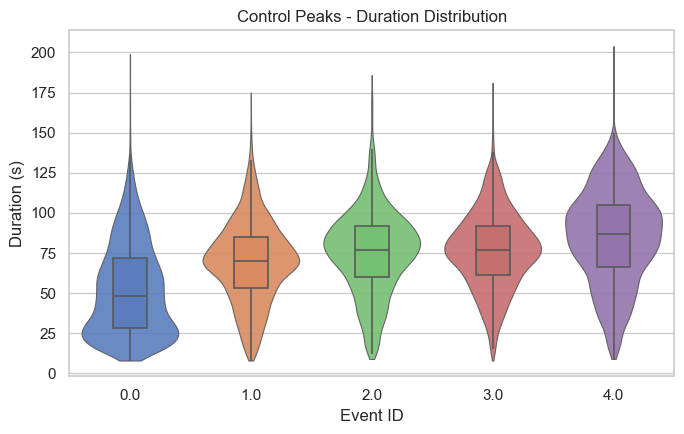

[2025-08-16 17:54:15] [INFO] calcium: plot_violin: removed 132 outliers out of 27502 on 'Prominence (noise std units)' (lower=-352.28, upper=714.7)


c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:954: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(**violin_kwargs)
c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:984: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp_ax = sns.boxplot(


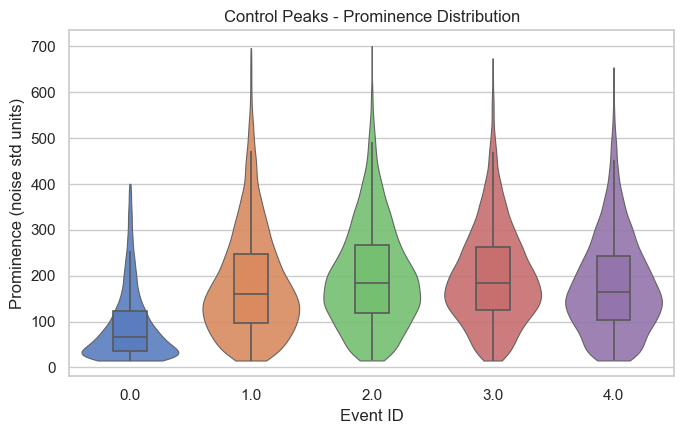

In [4]:
mapping_events_to_peaks = control_events.loc[control_events["Event type"] == "GlobalEvent", ["Event ID", "dataset"]]
subset_peaks_global_events = control_peaks.merge(mapping_events_to_peaks, 
                                                     on=["Event ID", "dataset"], 
                                                     how="inner", 
                                                     validate="m:1")

plot_violin(
    df=subset_peaks_global_events,
    x="Event ID",
    y="Duration (s)",
    title="Control Peaks - Duration Distribution",
    ylabel="Duration (s)",
    xlabel="Event ID",
    width=0.8,
    filter_outliers=True,
    outliers_bounds=(3, 3),
    outliers_bygroup="Event ID",
    dodge=False
)
plot_violin(
    df=subset_peaks_global_events,
    x="Event ID",
    y="Prominence (noise std units)",
    title="Control Peaks - Prominence Distribution",
    ylabel="Prominence (noise std units)",
    xlabel="Event ID",
    width=0.8,
    filter_outliers=True,
    outliers_bounds=(3, 3),
    outliers_bygroup="Event ID",
    dodge=False
)

[2025-08-16 17:54:15] [INFO] calcium: plot_points_mean_std: removed 0 outliers out of 23 on 'Time to 50% (s)' (lower=22, upper=99)


c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:1243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(


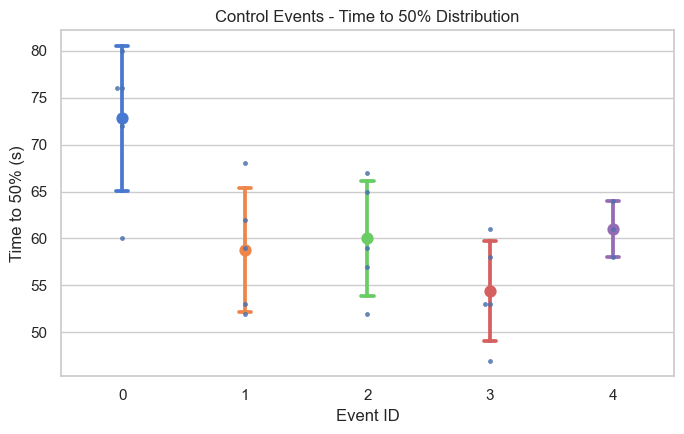

[2025-08-16 17:54:16] [INFO] calcium: plot_points_mean_std: removed 0 outliers out of 23 on 'Normalized peak rate at 50% (% of peaks/s)' (lower=-0.45, upper=4.45)


c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:1243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(


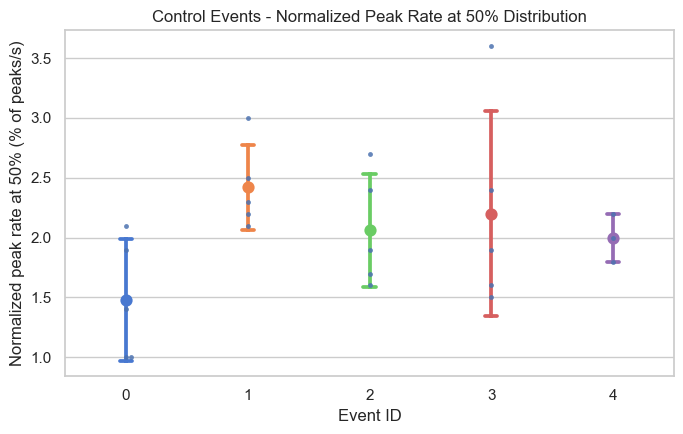

c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:1243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(


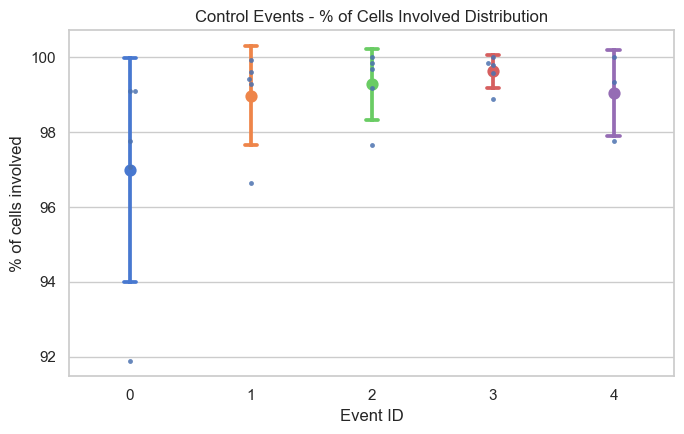

In [5]:
global_events = control_events[control_events["Event type"] == "GlobalEvent"].copy()

cell_counts = cells.groupby("dataset").size().rename("Total number of cells").reset_index()
global_events = global_events.merge(cell_counts, on="dataset", how="left")

global_events["% of cells involved"] = (100 * global_events["Number of cells involved"] / global_events["Total number of cells"]).round(2)

plot_points_mean_std(
    df=global_events,
    x="Event ID",
    y="Time to 50% (s)",
    title="Control Events - Time to 50% Distribution",
    ylabel="Time to 50% (s)",
    xlabel="Event ID",
    filter_outliers=True,
    outliers_bounds=(3, 3)
)
plot_points_mean_std(
    df=global_events,
    x="Event ID",
    y="Normalized peak rate at 50% (% of peaks/s)",
    title="Control Events - Normalized Peak Rate at 50% Distribution",
    ylabel="Normalized peak rate at 50% (% of peaks/s)",
    xlabel="Event ID",
    filter_outliers=True,
    outliers_bounds=(3, 3)
)
plot_points_mean_std(
    df=global_events,
    x="Event ID",
    y="% of cells involved",
    title="Control Events - % of Cells Involved Distribution",
    ylabel="% of cells involved",
    xlabel="Event ID",
    filter_outliers=False,
    outliers_bounds=(3, 3)
)

### Inter-peak intervals

dataset  periodicity  frequency
0   20250326_IS1     0.911429   0.004149
1   20250326_IS3     0.740251        NaN
2   20250404_IS1     0.839482   0.003322
3  20250409_IS09     0.982643   0.002865
4  20250409_IS11     0.905170   0.003021

[2025-08-16 17:54:16] [INFO] calcium: plot_points_mean_std: removed 0 outliers out of 18 on 'interval' (lower=-57.25, upper=649.75)


c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:1243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(


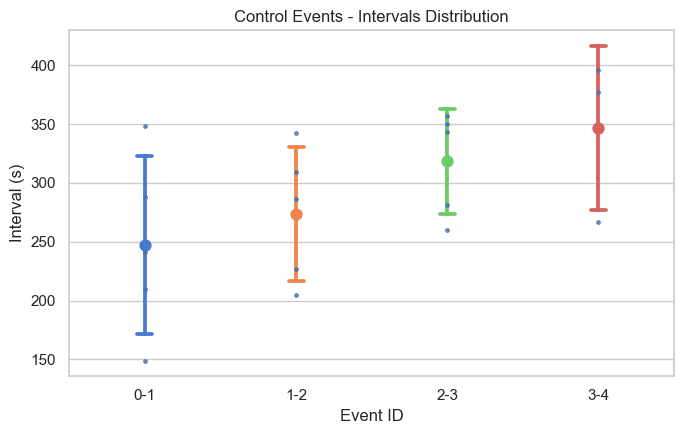

Periodicity 
 - N = 5
 - Mean = 0.88 a.u.
 - Std = 0.09 a.u.

Frequency 
 - N = 4
 - Mean = 0.0033 Hz
 - Std = 0.0006 Hz



In [6]:
intervals_list = []
periodicity_list = []

for dataset_name, df_subset in global_events.groupby("dataset"):
    intervals, periodicity, frequency = analyze_peak_intervals(df_subset["Event peak time (s)"].tolist())
    periodicity_list.append({
        "dataset": dataset_name,
        "periodicity": periodicity,
        "frequency": frequency if periodicity > 0.8 else None
    })
    for idx, val in enumerate(intervals):
        intervals_list.append({
            "dataset": dataset_name,
            "index": f"{idx}-{idx+1}",
            "interval": val
        })

intervals_df = pd.DataFrame(intervals_list)
periodicity_df = pd.DataFrame(periodicity_list)

display(periodicity_df)

plot_points_mean_std(
    df=intervals_df,
    x="index",
    y="interval",
    title="Control Events - Intervals Distribution",
    ylabel="Interval (s)",
    xlabel="Event ID",
    filter_outliers=True,
    outliers_bounds=(3, 3)
)

print(f"Periodicity \n - N = {periodicity_df['periodicity'].count()}\n - Mean = {periodicity_df['periodicity'].mean():.2f} a.u.\n - Std = {periodicity_df['periodicity'].std():.2f} a.u.\n")
print(f"Frequency \n - N = {periodicity_df['frequency'].count()}\n - Mean = {periodicity_df['frequency'].mean():.4f} Hz\n - Std = {periodicity_df['frequency'].std():.4f} Hz\n")


### Mapping of cell occurences in global events

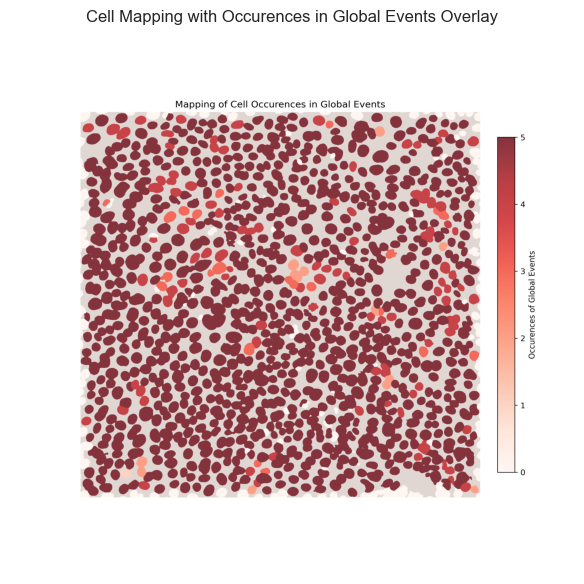

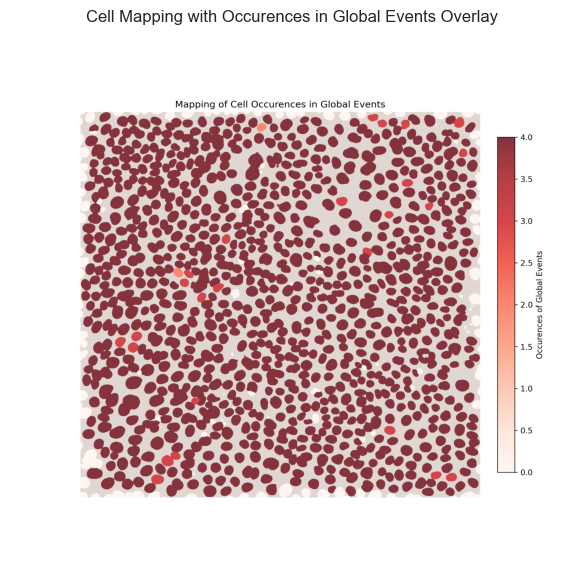

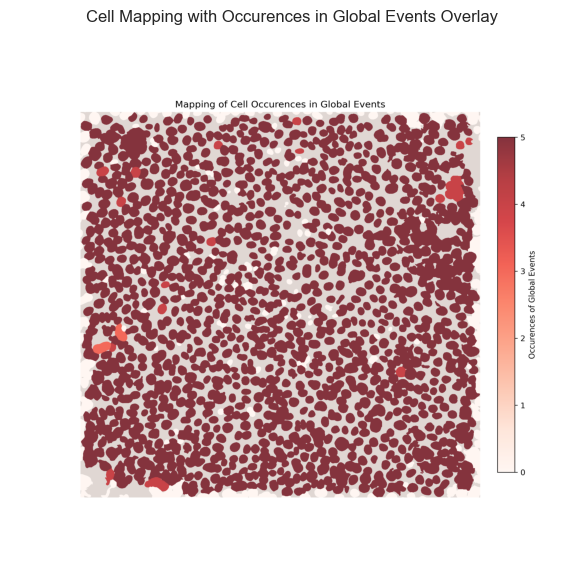

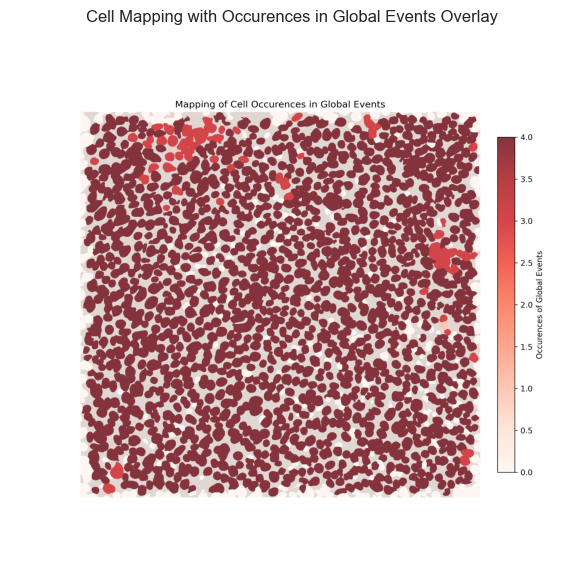

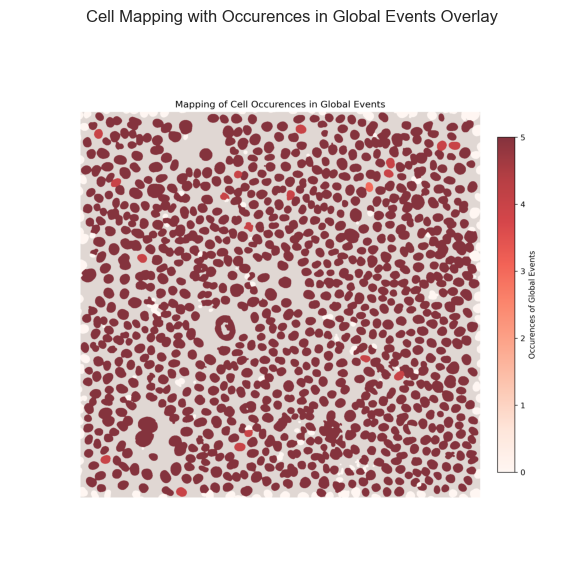

In [7]:
for (date, image_sequence), df_subset in global_events.groupby(["date", "image_sequence"]):
    visualize_image(
        image_source={f"{date} - {image_sequence}": f"D:/Mateo/{date}/Output/{image_sequence}"},
        image_name="cell-mapping/cell_occurences_in_global_events_overlay.png",
        title="Cell Mapping with Occurences in Global Events Overlay",
        figsize=(6, 6)
    )

### Early peakers in GE

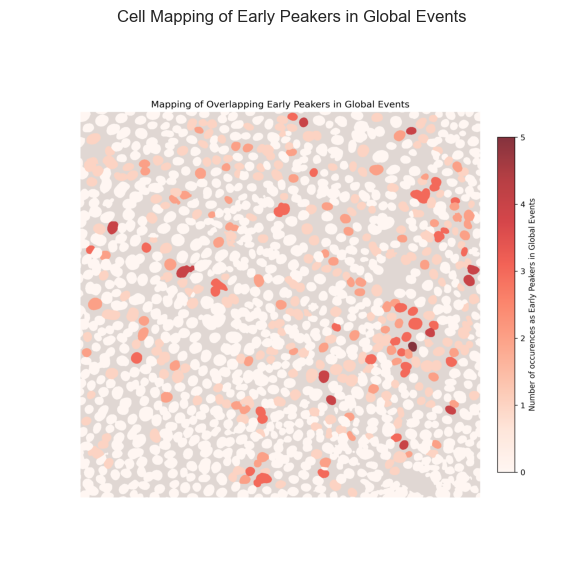

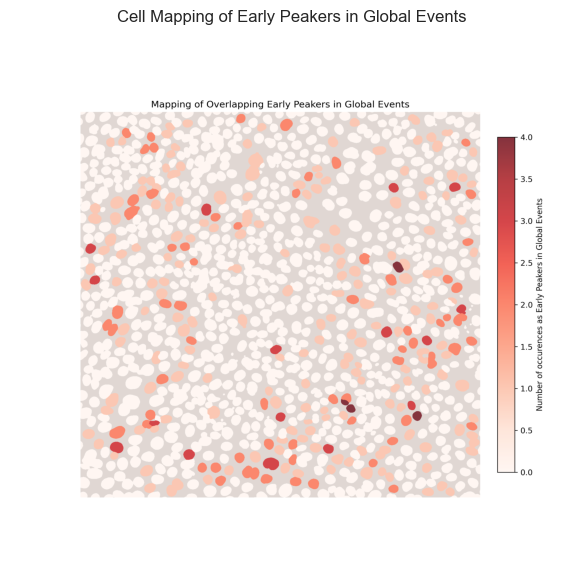

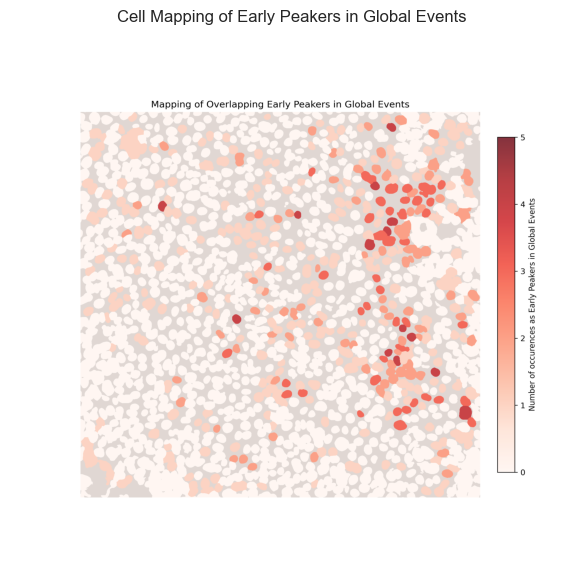

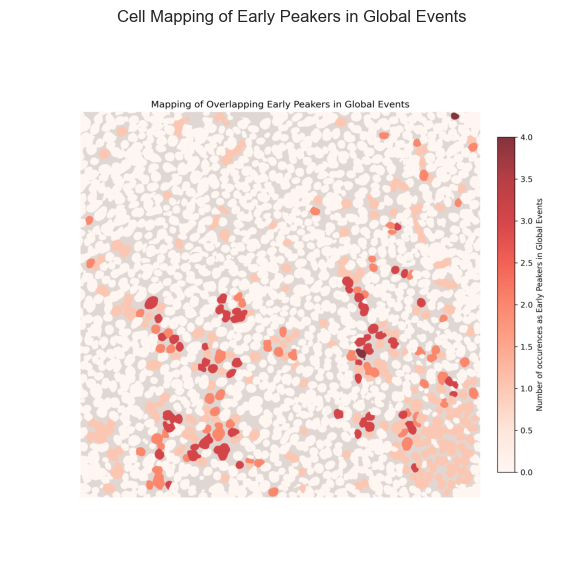

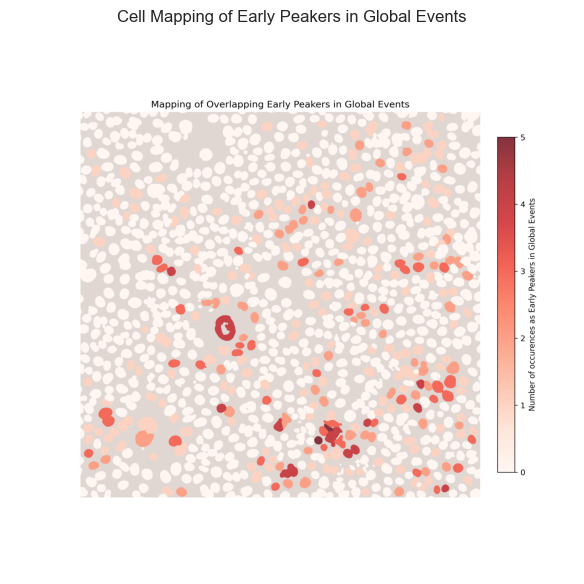

In [8]:
for (date, image_sequence), df_subset in global_events.groupby(["date", "image_sequence"]):
    visualize_image(
        image_source={f"{date} - {image_sequence}": f"D:/Mateo/{date}/Output/{image_sequence}"},
        image_name="cell-mapping/global_events/global_event_overlap_early_peakers_overlay.png",
        title="Cell Mapping of Early Peakers in Global Events",
        figsize=(6, 6)
    )

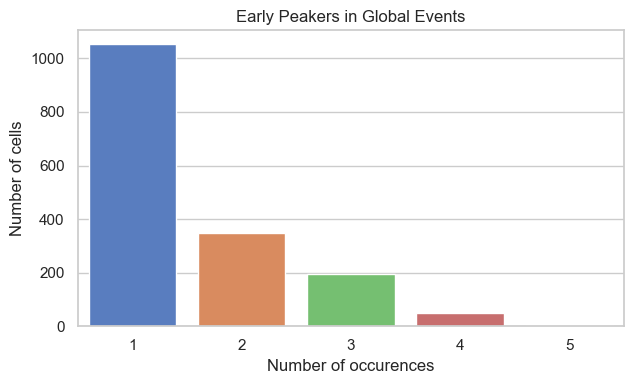

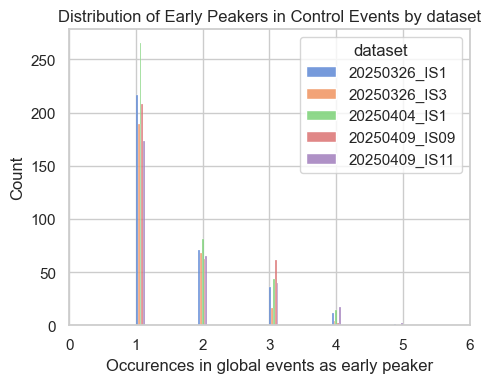

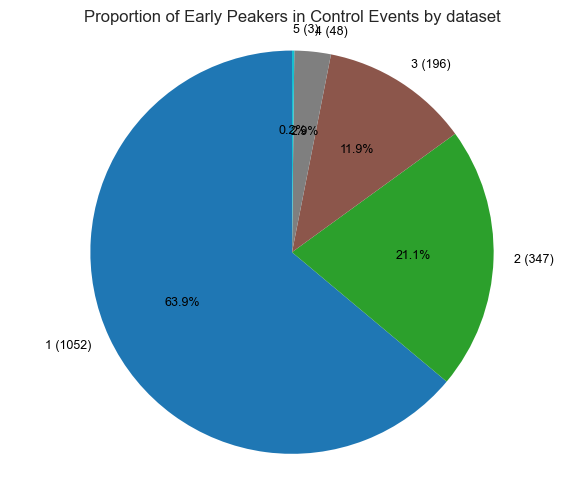

In [9]:
early_peakers_df = (
    control_cells[control_cells["Occurences in global events as early peaker"] > 0]
    .groupby("Occurences in global events as early peaker")
    .size()
    .reset_index(name="Number of cells")
    .rename(columns={"Occurences in global events as early peaker": "Number of occurences"})
    .sort_values("Number of occurences")
)

plot_bar(
    df=early_peakers_df,
    axis_column="Number of occurences",
    value_column="Number of cells",
    title="Early Peakers in Global Events",
    xlabel="Number of occurences",
    ylabel="Number of cells",
    rotation=0
)

plot_histogram_by_group(
    df=control_cells[control_cells["Occurences in global events as early peaker"] > 0],
    value_column="Occurences in global events as early peaker",
    group_column="dataset",
    title="Distribution of Early Peakers in Control Events by dataset",
    x_axis_boundaries=(0,6)
)

plot_pie_chart(
    df=control_cells[control_cells["Occurences in global events as early peaker"] > 0],
    column="Occurences in global events as early peaker",
    title="Proportion of Early Peakers in Control Events by dataset"
)

### Cells occurences in different events

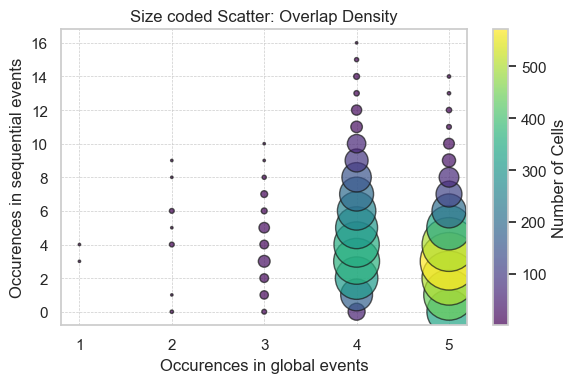

In [10]:
plot_scatter_size_coded(
    df=control_cells,
    x_col="Occurences in global events",
    y_col="Occurences in sequential events",
    size_scale=3
)

## SEQUENTIAL EVENTS ANALYSIS

In [11]:
sequential_events = control_events[control_events["Event type"] == "SequentialEvent"].copy()

### Mapping of cell occurences in sequential events

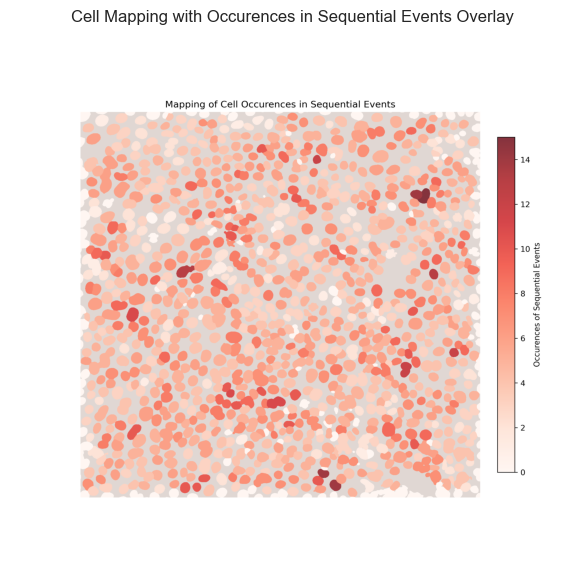

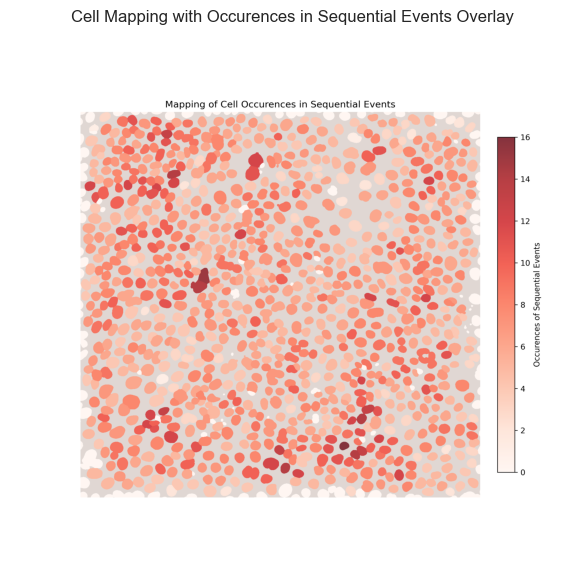

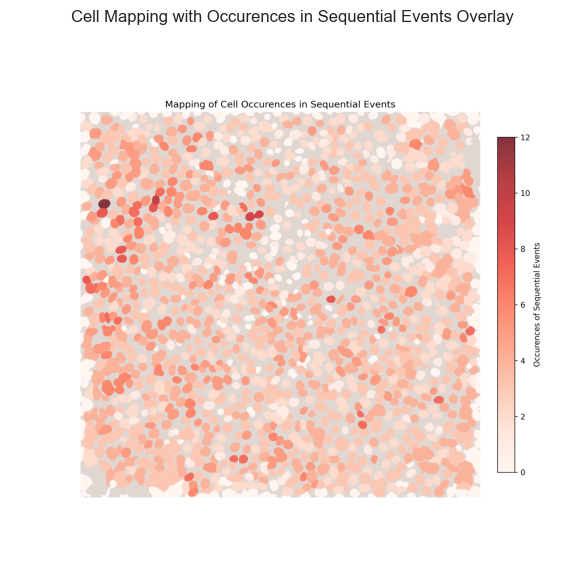

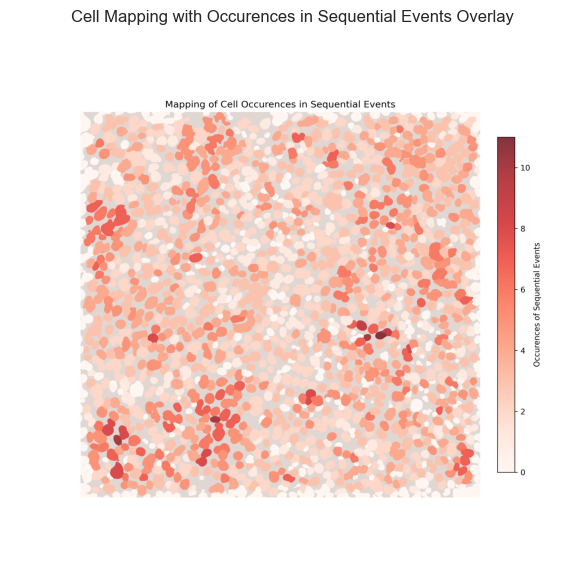

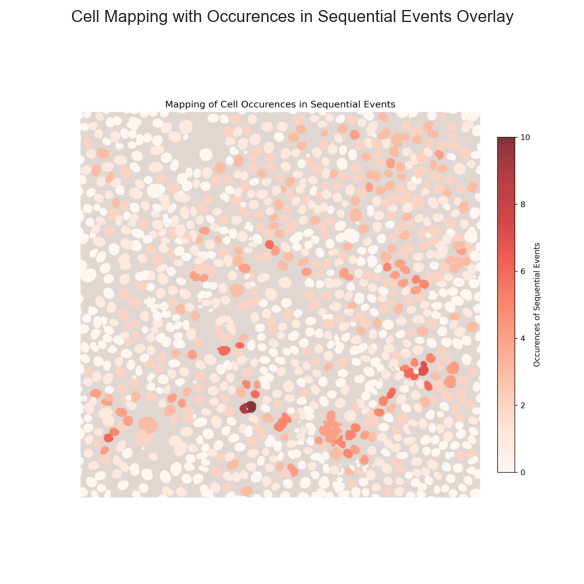

In [12]:
for (date, image_sequence), df_subset in sequential_events.groupby(["date", "image_sequence"]):
    visualize_image(
        image_source={f"{date} - {image_sequence}": f"D:/Mateo/{date}/Output/{image_sequence}"},
        image_name="cell-mapping/cell_occurences_in_sequential_events_overlay.png",
        title="Cell Mapping with Occurences in Sequential Events Overlay",
        figsize=(6, 6)
    )

### Peak features repeatability

[2025-08-16 17:55:15] [INFO] calcium: plot_violin: removed 378 outliers out of 21954 on 'Duration (s)' (lower=-36, upper=90)


c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:954: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(**violin_kwargs)
c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:984: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp_ax = sns.boxplot(


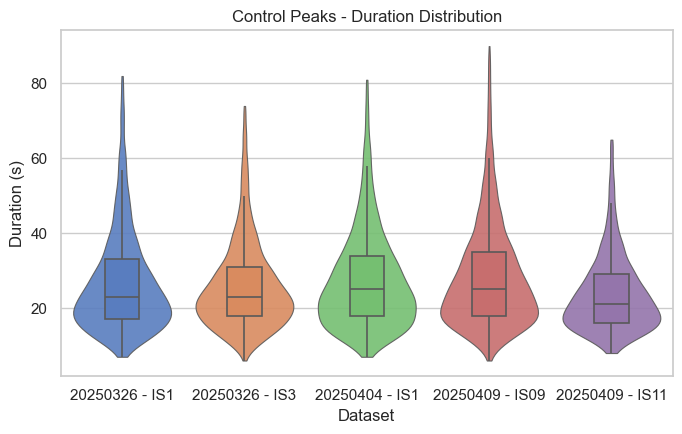

[2025-08-16 17:55:15] [INFO] calcium: plot_violin: removed 651 outliers out of 21954 on 'Prominence (noise std units)' (lower=-243.1, upper=392.5)


c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:954: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(**violin_kwargs)
c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:984: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp_ax = sns.boxplot(


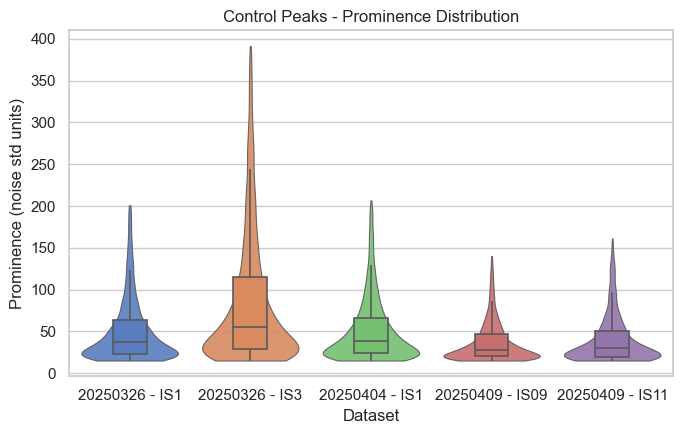

[2025-08-16 17:55:16] [INFO] calcium: plot_violin: removed 123 outliers out of 4775 on 'Number of cells involved' (lower=-10, upper=18)


c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:954: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(**violin_kwargs)
c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:984: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp_ax = sns.boxplot(


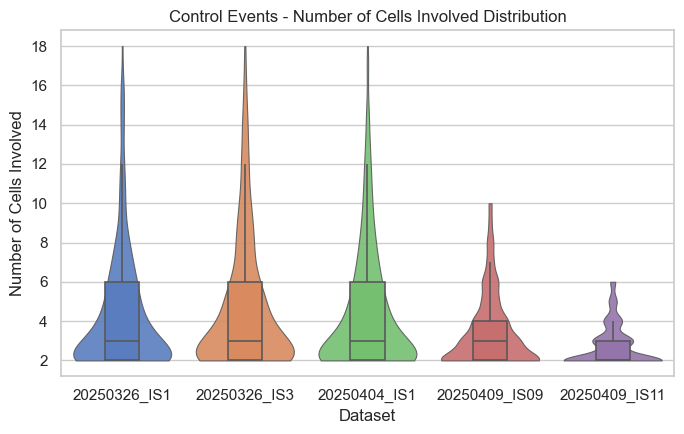

In [37]:
control_peaks["dataset name"] = control_peaks['date'].astype(str) + " - " + control_peaks['image_sequence'].astype(str)

mapping_events_to_peaks = control_events.loc[control_events["Event type"] == "SequentialEvent", ["Event ID", "dataset"]]
subset_peaks_sequential_events = control_peaks.merge(mapping_events_to_peaks, 
                                                     on=["Event ID", "dataset"], 
                                                     how="inner", 
                                                     validate="m:1")

plot_violin(
    df=subset_peaks_sequential_events,
    x="dataset name",
    y="Duration (s)",
    title="Control Peaks - Duration Distribution",
    ylabel="Duration (s)",
    xlabel="Dataset",
    width=0.8,
    filter_outliers=True,
    outliers_bounds=(3, 3),
    dodge=False,
    outliers_bygroup="dataset name",
)
plot_violin(
    df=subset_peaks_sequential_events,
    x="dataset name",
    y="Prominence (noise std units)",
    title="Control Peaks - Prominence Distribution",
    ylabel="Prominence (noise std units)",
    xlabel="Dataset",
    width=0.8,
    filter_outliers=True,
    outliers_bounds=(3, 3),
    dodge=False,
    outliers_bygroup="dataset name"
)

control_events["dataset name"] = control_events['date'].astype(str) + " - " + control_events['image_sequence'].astype(str)

plot_violin(
    df=sequential_events,
    x="dataset",
    y="Number of cells involved",
    title="Control Events - Number of Cells Involved Distribution",
    ylabel="Number of Cells Involved",
    xlabel="Dataset",
    width=0.8,
    filter_outliers=True,
    outliers_bounds=(3, 3),
    dodge=False,
    outliers_bygroup="dataset"
)

[2025-08-16 17:54:46] [INFO] calcium: plot_violin: removed 521 outliers out of 17179 on 'Speed (um/s)' (lower=-16.555, upper=25.385)


c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:954: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(**violin_kwargs)
c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:984: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp_ax = sns.boxplot(


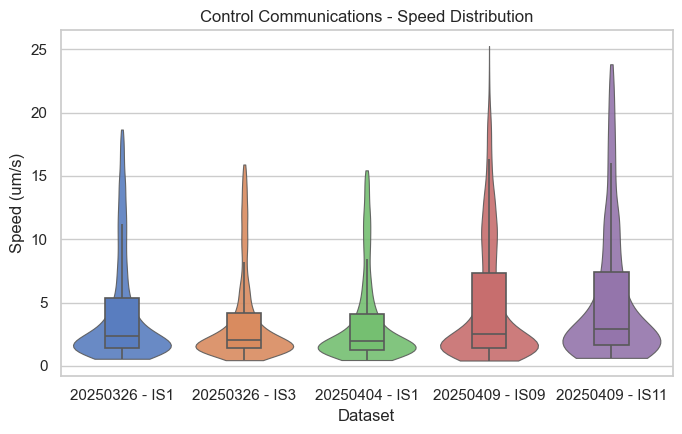

In [14]:
control_communications["dataset name"] = control_communications['date'].astype(str) + " - " + control_communications['image_sequence'].astype(str)

plot_violin(
    df=control_communications,
    x="dataset name",
    y="Speed (um/s)",
    title="Control Communications - Speed Distribution",
    ylabel="Speed (um/s)",
    xlabel="Dataset",
    width=0.8,
    filter_outliers=True,
    outliers_bounds=(3, 3),
    dodge=False,
    outliers_bygroup="dataset name"
)

c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:1243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(


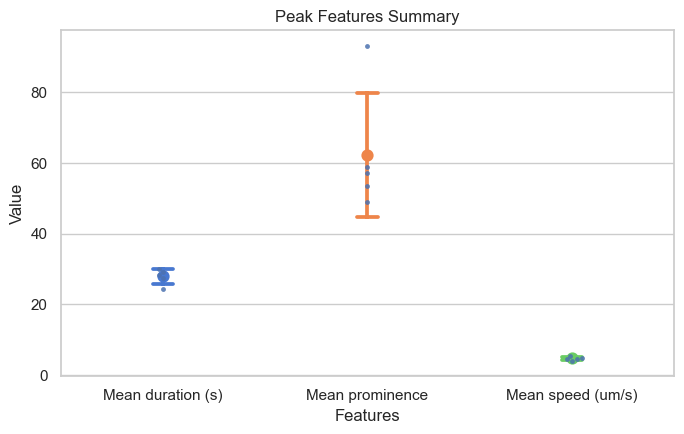

In [15]:
peak_features_summary_list = []

for dataset_name, df_subset in subset_peaks_sequential_events.groupby("dataset name"):
    peak_features_summary_list.append({
        "dataset name": dataset_name,
        "Value type": "Mean duration (s)",
        "Value": df_subset["Duration (s)"].mean()
    })
    peak_features_summary_list.append({
        "dataset name": dataset_name,
        "Value type": "Mean prominence",
        "Value": df_subset["Prominence (noise std units)"].mean()
    })

for dataset_name, df_subset in control_communications.groupby("dataset name"):
    peak_features_summary_list.append({
        "dataset name": dataset_name,
        "Value type": "Mean speed (um/s)",
        "Value": df_subset["Speed (um/s)"].mean()
    })

peak_features_summary_df = pd.DataFrame(peak_features_summary_list)

plot_points_mean_std(
    df=peak_features_summary_df,
    x="Value type",
    y="Value",
    title="Peak Features Summary",
    ylabel="Value",
    xlabel="Features"
)#bybebye

### Cell-cell communcation & nucleus distances

In [16]:
pairs_communication_df = build_neighbor_pair_stats(
    cells_df=control_cells,
    comm_df=control_communications,
    dataset_col="dataset",
    cell_id_col="Cell ID",
    centroid_x_col="Centroid X coordinate (um)",
    centroid_y_col="Centroid Y coordinate (um)",
    neighbors_col="Neighbors (labels)",
    edge_cols=("Cell ID", "Neighbor ID")
    )

[2025-08-16 17:54:47] [INFO] calcium: build_neighbor_pair_stats: built 16198 pairs across 5 datasets (mean distance=16.09 um)


[2025-08-16 17:54:47] [INFO] calcium: plot_histogram: removed 3 outliers out of 4293 on 'Distance (um)' (lower=-5, upper=36.58)


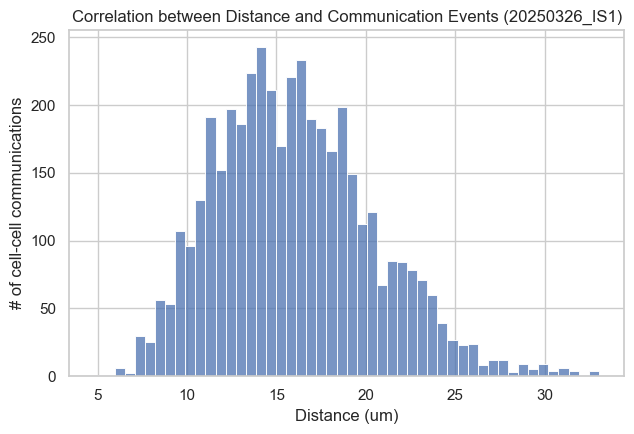

[2025-08-16 17:54:47] [INFO] calcium: plot_histogram: removed 1 outliers out of 5557 on 'Distance (um)' (lower=-4.12, upper=36.76)


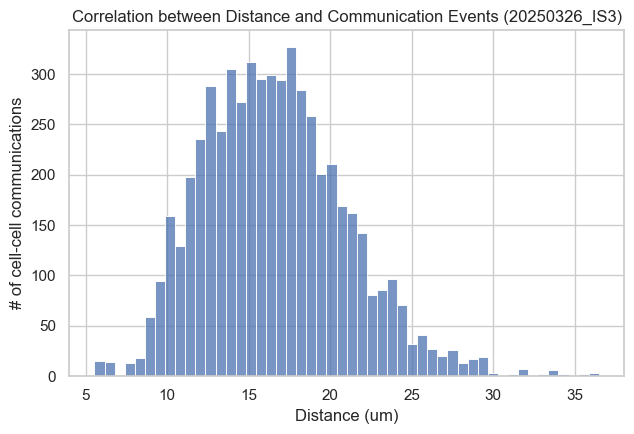

[2025-08-16 17:54:47] [INFO] calcium: plot_histogram: removed 1 outliers out of 3206 on 'Distance (um)' (lower=-5, upper=34.48)


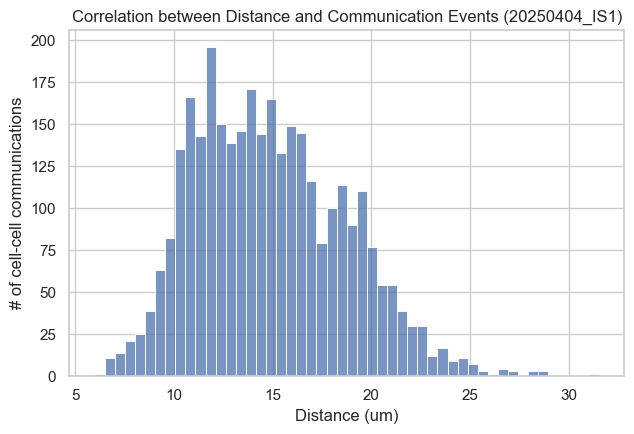

[2025-08-16 17:54:47] [INFO] calcium: plot_histogram: removed 2 outliers out of 3192 on 'Distance (um)' (lower=-5.91, upper=34.2)


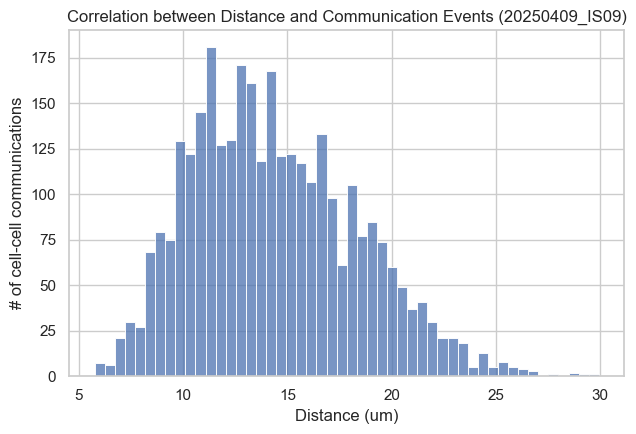

[2025-08-16 17:54:47] [INFO] calcium: plot_histogram: removed 1 outliers out of 931 on 'Distance (um)' (lower=-6.95, upper=38.83)


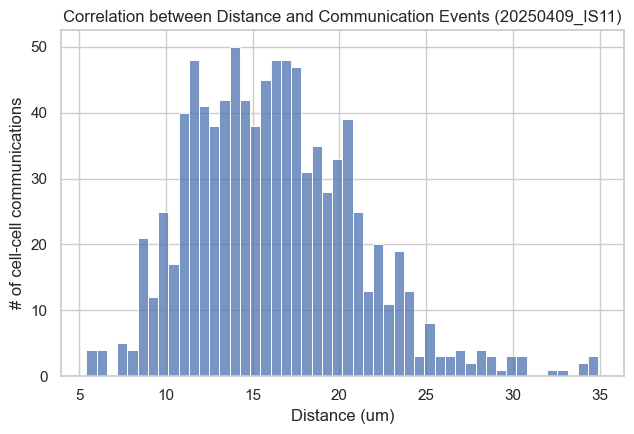

In [17]:
for dataset_name, df_subset in control_communications.groupby("dataset"):
    plot_histogram(
        df=df_subset,
        column="Distance (um)",
        title=f"Correlation between Distance and Communication Events ({dataset_name})",
        ylabel="# of cell-cell communications",
        bin_count=50,
        filter_outliers=True,
        outliers_bounds=(3,3)
    )

[2025-08-16 17:54:48] [INFO] calcium: plot_histogram: removed 2 outliers out of 3086 on 'distance_um' (lower=-4.1274, upper=36.679)


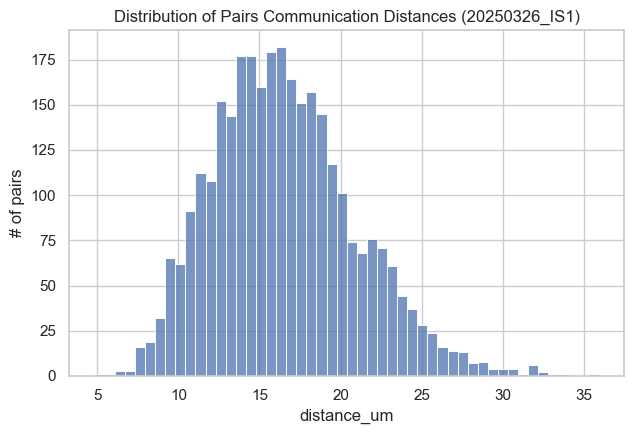

[2025-08-16 17:54:48] [INFO] calcium: plot_histogram: removed 1 outliers out of 2816 on 'distance_um' (lower=-3.3527, upper=37.14)


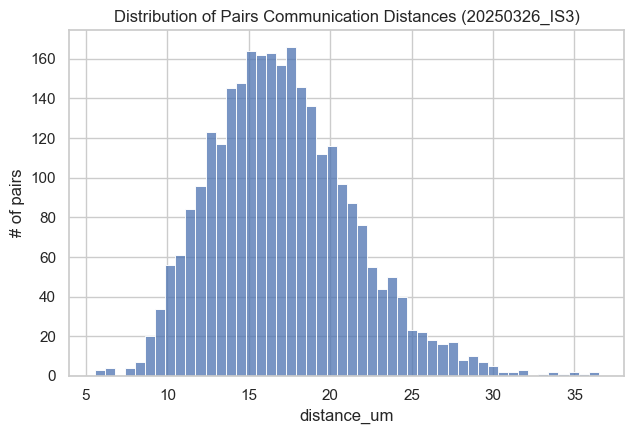

[2025-08-16 17:54:48] [INFO] calcium: plot_histogram: removed 1 outliers out of 3556 on 'distance_um' (lower=-5.3121, upper=35.86)


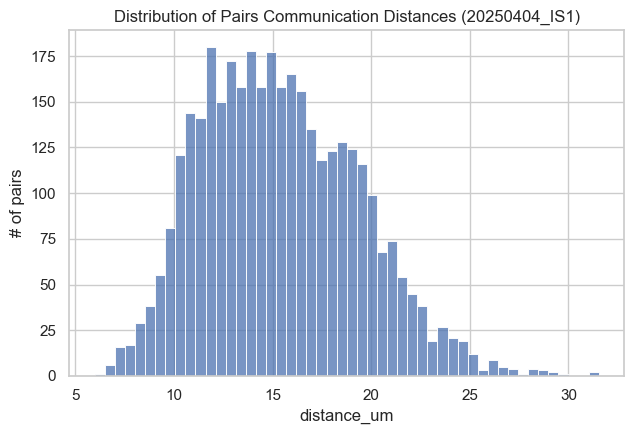

[2025-08-16 17:54:48] [INFO] calcium: plot_histogram: removed 1 outliers out of 3830 on 'distance_um' (lower=-4.5963, upper=33.905)


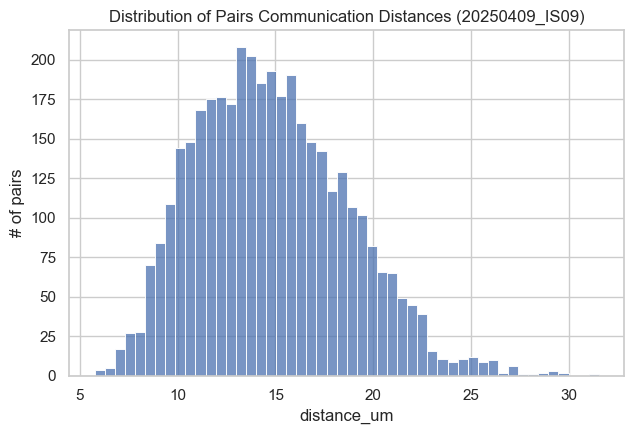

[2025-08-16 17:54:48] [INFO] calcium: plot_histogram: removed 6 outliers out of 2910 on 'distance_um' (lower=-4.9786, upper=38.588)


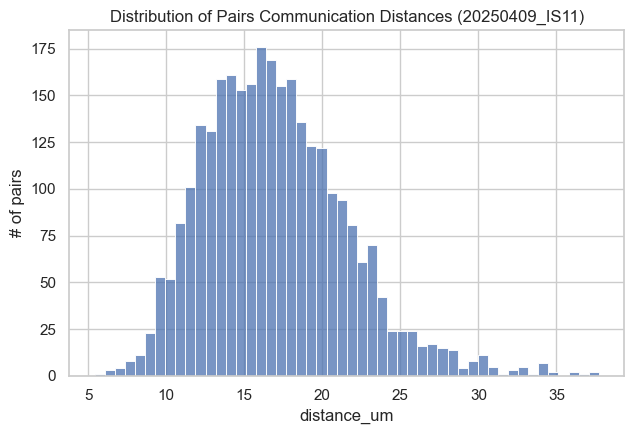

In [18]:
for dataset_name, df_subset in pairs_communication_df.groupby("dataset"):
    plot_histogram(
        df=df_subset,
        column="distance_um",
        title=f"Distribution of Pairs Communication Distances ({dataset_name})",
        ylabel="# of pairs",
        bin_count=50,
        filter_outliers=True,
        outliers_bounds=(3,3)
    )

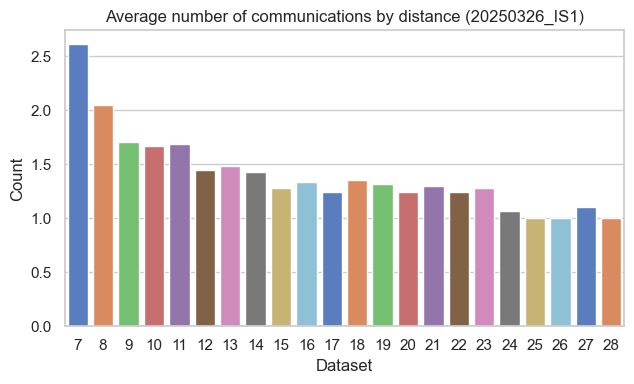

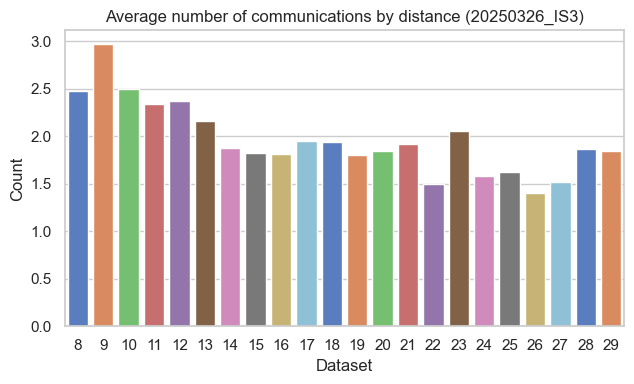

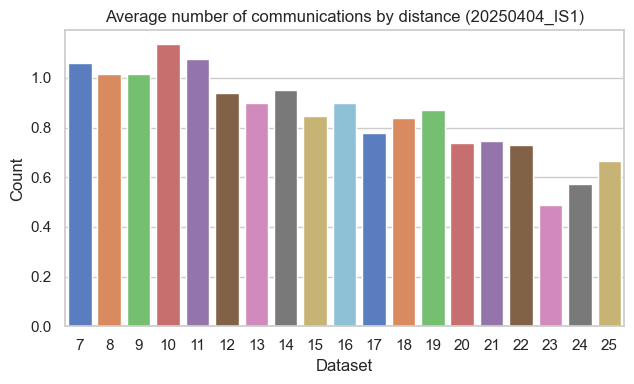

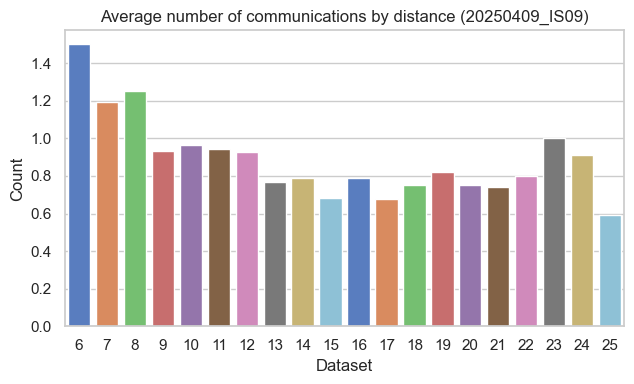

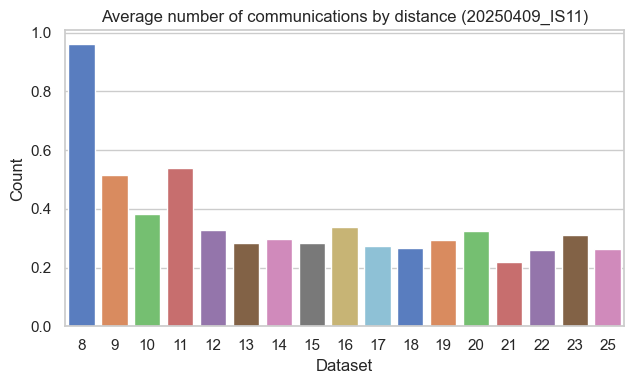

In [19]:
pairs_communication_df["Distance truncated (um)"] = np.floor(pairs_communication_df["distance_um"]).astype(int)
average = pairs_communication_df.groupby(["dataset", "Distance truncated (um)"], as_index=False)
comm_by_distance_df = average.agg(n_pairs=("n_communications", "size"), total_communications=("n_communications", "sum"))
comm_by_distance_df["average number of communications"] = comm_by_distance_df["total_communications"] / comm_by_distance_df["n_pairs"]

for dataset_name, df_subset in comm_by_distance_df.groupby("dataset"):
    plot_bar(
        df=df_subset[(df_subset["total_communications"]>=10)&(df_subset["n_pairs"]>=10)],
        axis_column="Distance truncated (um)",
        value_column="average number of communications",
        rotation=0,
        title=f"Average number of communications by distance ({dataset_name})"
    )


[2025-08-16 17:54:50] [INFO] calcium: plot_histogram: removed 8 outliers out of 17179 on 'Distance (um)' (lower=-6.95, upper=38.83)


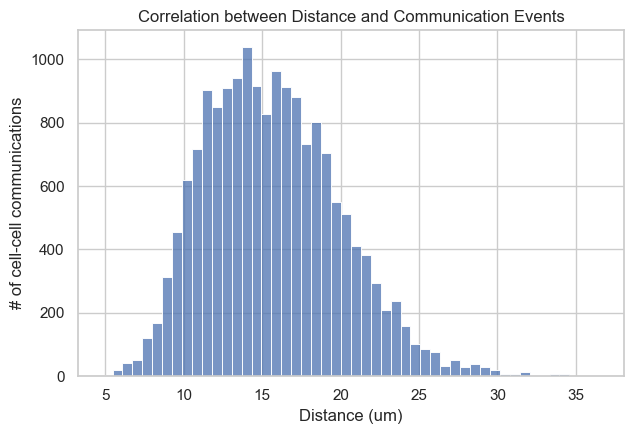

[2025-08-16 17:54:50] [INFO] calcium: plot_histogram: removed 11 outliers out of 16198 on 'distance_um' (lower=-5.3121, upper=38.588)


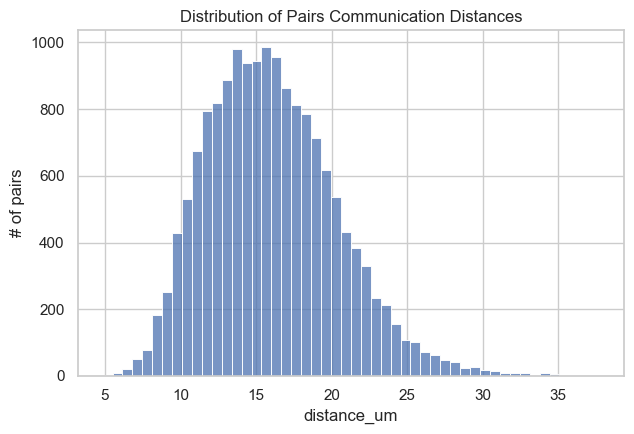

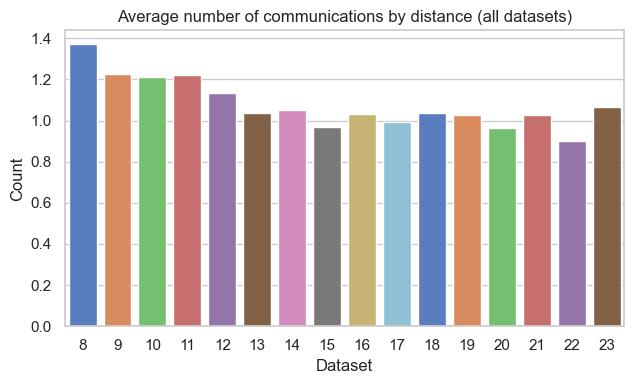

In [20]:
plot_histogram(
    df=control_communications,
    column="Distance (um)",
    title="Correlation between Distance and Communication Events",
    ylabel="# of cell-cell communications",
    bin_count=50,
    filter_outliers=True,
    outliers_bounds=(3,3),
    outliers_bygroup="dataset"
)
plot_histogram(
    df=pairs_communication_df,
    column="distance_um",
    title="Distribution of Pairs Communication Distances",
    ylabel="# of pairs",
    bin_count=50,
    filter_outliers=True,
    outliers_bounds=(3,3),
    outliers_bygroup="dataset"
)

overall_comm_by_distance = (
    comm_by_distance_df
    .groupby("Distance truncated (um)", as_index=False)
    .agg(
        n_pairs=("n_pairs", "sum"),
        total_communications=("total_communications", "sum"),
    )
)
overall_comm_by_distance["average number of communications"] = (
    overall_comm_by_distance["total_communications"] / overall_comm_by_distance["n_pairs"]
)
#overall_comm_by_distance = overall_comm_by_distance[(overall_comm_by_distance["total_communications"]>=25) & 
#                                                    (overall_comm_by_distance["n_pairs"]>=25)]
plot_bar(
    df=overall_comm_by_distance[(overall_comm_by_distance["Distance truncated (um)"] >= 8) & (overall_comm_by_distance["Distance truncated (um)"] <= 23)],
    axis_column="Distance truncated (um)",
    value_column="average number of communications",
    rotation=0,
    title="Average number of communications by distance (all datasets)"
)

### Pair/Trios with high communication networks

In [21]:
# --- 1) Pair stats & per-dataset 95th percentile --------------------------------
pairs_communication_df = build_neighbor_pair_stats(
    cells_df=control_cells,
    comm_df=control_communications,
    dataset_col="dataset",
    cell_id_col="Cell ID",
    centroid_x_col="Centroid X coordinate (um)",
    centroid_y_col="Centroid Y coordinate (um)",
    neighbors_col="Neighbors (labels)",
    edge_cols=("Cell ID", "Neighbor ID")
)

# Per-dataset 95th percentile
pairs_communication_df["p95"] = (
    pairs_communication_df.groupby("dataset")["n_communications"]
    .transform(lambda s: s.quantile(0.95))
)

top_pair_communication_df = pairs_communication_df.loc[
    pairs_communication_df["n_communications"] >= pairs_communication_df["p95"],
    ["dataset", "Cell A", "Cell B", "n_communications"]
].copy()

# Canonical pair key in top pairs (Cell A < Cell B assumed)
top_pair_communication_df["pair_key"] = list(
    zip(top_pair_communication_df["Cell A"], top_pair_communication_df["Cell B"])
)

# --- 2) Communications tagging with (dataset, pair_key) -------------------------
origin_com = control_communications["Origin cell ID"]
cause_com = control_communications["Cause cell ID"]

# Canonicalize the pair for every communication row
control_communications["pair_key"] = list(
    zip(
        origin_com.where(origin_com <= cause_com, cause_com),
        cause_com.where(cause_com >= origin_com, origin_com),
    )
)

top_pairs_idx = pd.MultiIndex.from_frame(
    top_pair_communication_df[["dataset", "pair_key"]].drop_duplicates()
)

# Tag directly via MultiIndex.isin (safe to run many times)
control_communications = control_communications.copy()
control_communications["from_high_comm_pair"] = pd.MultiIndex.from_frame(
    control_communications[["dataset", "pair_key"]]
).isin(top_pairs_idx)

control_communications["from_high_comm_pair"] = control_communications["from_high_comm_pair"].fillna(False)

# --- 3) Peaks tagging with (dataset, Cell ID, Peak ID) --------------------------
peaks_in_top_comms = pd.concat(
    [
        control_communications.loc[
            control_communications["from_high_comm_pair"],
            ["dataset", "Origin cell ID", "Origin cell peak ID"],
        ].rename(columns={"Origin cell ID": "Cell ID", "Origin cell peak ID": "Peak ID"}),
        control_communications.loc[
            control_communications["from_high_comm_pair"],
            ["dataset", "Cause cell ID", "Cause cell peak ID"],
        ].rename(columns={"Cause cell ID": "Cell ID", "Cause cell peak ID": "Peak ID"}),
    ],
    ignore_index=True,
).drop_duplicates()

control_peaks["from_high_comm_pair"] = pd.MultiIndex.from_frame(
    control_peaks[["dataset", "Cell ID", "Peak ID"]]
).isin(
    pd.MultiIndex.from_frame(peaks_in_top_comms[["dataset", "Cell ID", "Peak ID"]])
)

# --- 4) Highly connected cells (per dataset) ------------------------------------
# Count, per dataset, how many top pairs each cell belongs to
cells_in_pairs = pd.concat(
    [
        top_pair_communication_df[["dataset", "Cell A"]].rename(columns={"Cell A": "Cell ID"}),
        top_pair_communication_df[["dataset", "Cell B"]].rename(columns={"Cell B": "Cell ID"}),
    ],
    ignore_index=True,
)

highly_connected_cells = (
    cells_in_pairs.groupby(["dataset", "Cell ID"]).size()
    .reset_index(name="Number of highly connected pairs")
)

# --- 5) Per-cell comm stats within top pairs, per dataset -----------------------
comms_high = control_communications.loc[
    control_communications["from_high_comm_pair"], ["dataset", "Origin cell ID", "Cause cell ID"]
].copy()

origin_counts = (
    comms_high.groupby("dataset")["Origin cell ID"]
    .value_counts()
    .rename("n_origin")
    .reset_index()
    .rename(columns={"Origin cell ID": "Cell ID"})
)

cause_counts = (
    comms_high.groupby("dataset")["Cause cell ID"]
    .value_counts()
    .rename("n_cause")
    .reset_index()
    .rename(columns={"Cause cell ID": "Cell ID"})
)

per_cell_comm = origin_counts.merge(
    cause_counts, on=["dataset", "Cell ID"], how="outer"
).fillna(0)

per_cell_comm[["n_origin", "n_cause"]] = per_cell_comm[["n_origin", "n_cause"]].astype(int)
per_cell_comm["Number of communications (top pairs)"] = (
    per_cell_comm["n_origin"] + per_cell_comm["n_cause"]
)
per_cell_comm["Origin ratio (origin/communications)"] = (
    per_cell_comm["n_origin"]
    / per_cell_comm["Number of communications (top pairs)"].replace({0: pd.NA})
)

# Merge into highly_connected_cells (by dataset + Cell ID)
highly_connected_cells = highly_connected_cells.merge(
    per_cell_comm[[
        "dataset", "Cell ID",
        "Number of communications (top pairs)",
        "n_origin",
        "Origin ratio (origin/communications)"
    ]],
    on=["dataset", "Cell ID"],
    how="left"
)

# Fill any missing stats
highly_connected_cells[["Number of communications (top pairs)", "n_origin"]] = (
    highly_connected_cells[["Number of communications (top pairs)", "n_origin"]]
    .fillna(0).astype(int)
)
highly_connected_cells["Origin ratio (origin/communications)"] = (
    highly_connected_cells["Origin ratio (origin/communications)"].fillna(0.0)
)

highly_connected_cells["Highly connected pairs"] = highly_connected_cells["Number of highly connected pairs"].apply(lambda x: True if x > 2 else False)

[2025-08-16 17:54:50] [INFO] calcium: build_neighbor_pair_stats: built 16198 pairs across 5 datasets (mean distance=16.09 um)


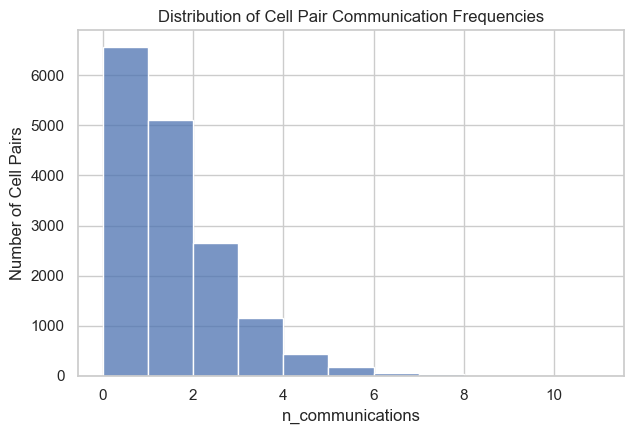

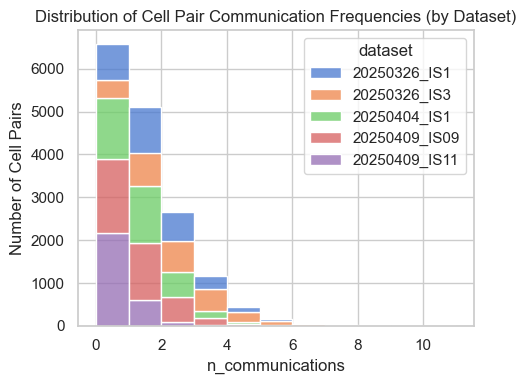

In [22]:
# Optional plot (all datasets together). If you prefer per-dataset, loop/group and plot.
plot_histogram(
    df=pairs_communication_df,
    column="n_communications",
    title="Distribution of Cell Pair Communication Frequencies",
    ylabel="Number of Cell Pairs",
    bin_width=1,
    filter_outliers=False,
    outliers_bounds=(3, 3)
)

plot_histogram_by_group(
    df=pairs_communication_df,
    value_column="n_communications",
    group_column="dataset",
    title="Distribution of Cell Pair Communication Frequencies (by Dataset)",
    ylabel="Number of Cell Pairs",
    bin_width=1,
    multiple="stack"
)

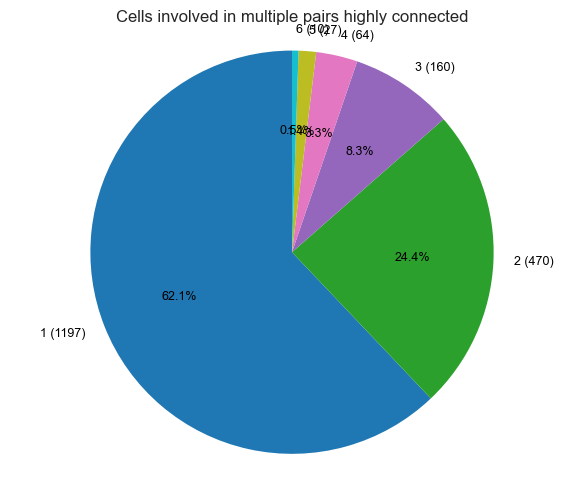

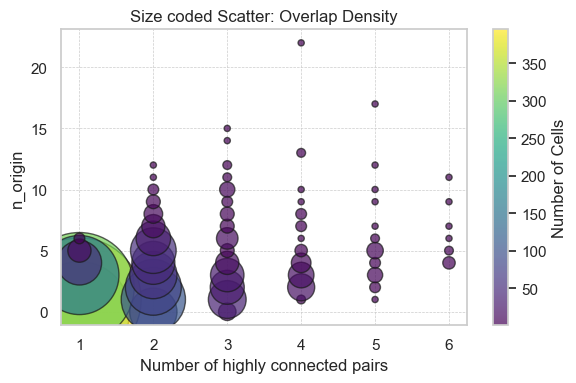

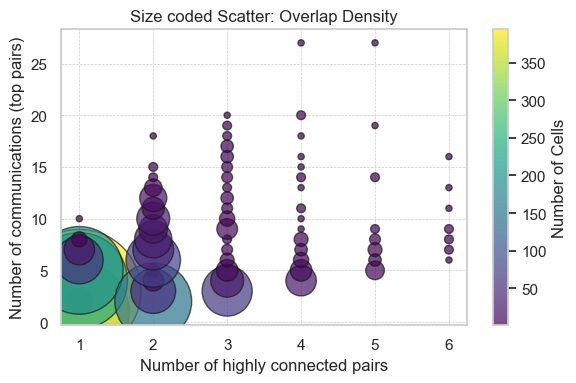

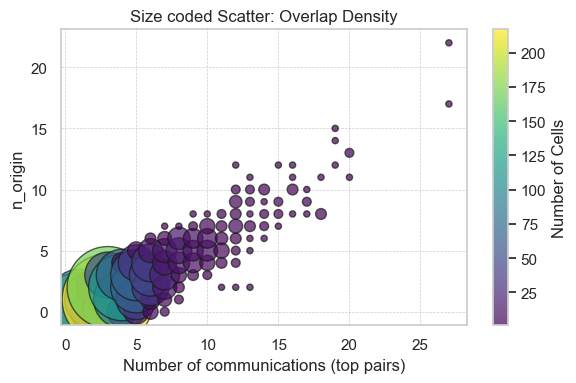

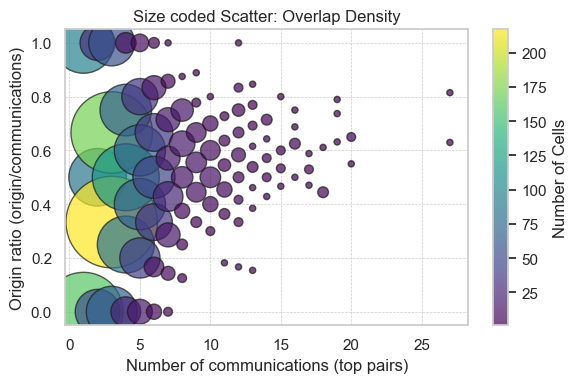

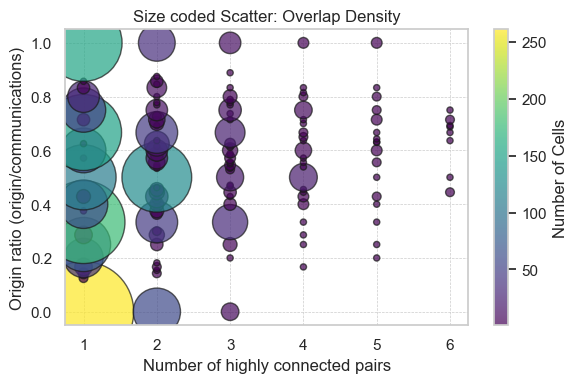

In [23]:
plot_pie_chart(
    df=highly_connected_cells,
    column="Number of highly connected pairs",
    title="Cells involved in multiple pairs highly connected"
)

plot_scatter_size_coded(
    df=highly_connected_cells,
    x_col="Number of highly connected pairs",
    y_col="n_origin"
)

plot_scatter_size_coded(
    df=highly_connected_cells,
    x_col="Number of highly connected pairs",
    y_col="Number of communications (top pairs)"
)

plot_scatter_size_coded(
    df=highly_connected_cells,
    x_col="Number of communications (top pairs)",
    y_col="n_origin"
)

plot_scatter_size_coded(
    df=highly_connected_cells,
    x_col="Number of communications (top pairs)",
    y_col="Origin ratio (origin/communications)"
)

plot_scatter_size_coded(
    df=highly_connected_cells,
    x_col="Number of highly connected pairs",
    y_col="Origin ratio (origin/communications)"
)

c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:1243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(


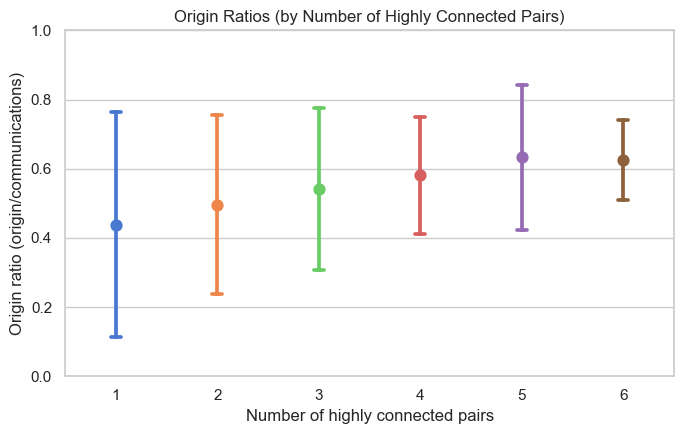

In [24]:
plot_points_mean_std(
    df=highly_connected_cells,
    x="Number of highly connected pairs",
    y="Origin ratio (origin/communications)",
    title="Origin Ratios (by Number of Highly Connected Pairs)",
    show_points=False,
    y_axis_boundaries=(0, 1)
)

[2025-08-16 17:54:52] [INFO] calcium: plot_violin: removed 362 outliers out of 21954 on 'Duration (s)' (lower=-33, upper=86)


c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:954: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(**violin_kwargs)
c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:984: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp_ax = sns.boxplot(


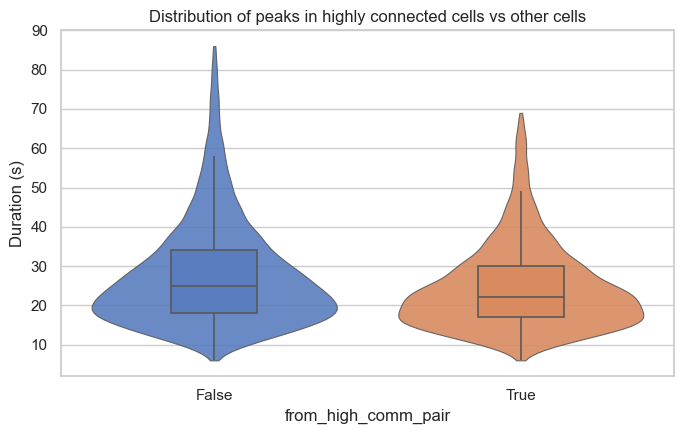

[2025-08-16 17:54:52] [INFO] calcium: plot_violin: removed 919 outliers out of 21954 on 'Prominence (noise std units)' (lower=-142.4, upper=244.7)


c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:954: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(**violin_kwargs)
c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:984: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp_ax = sns.boxplot(


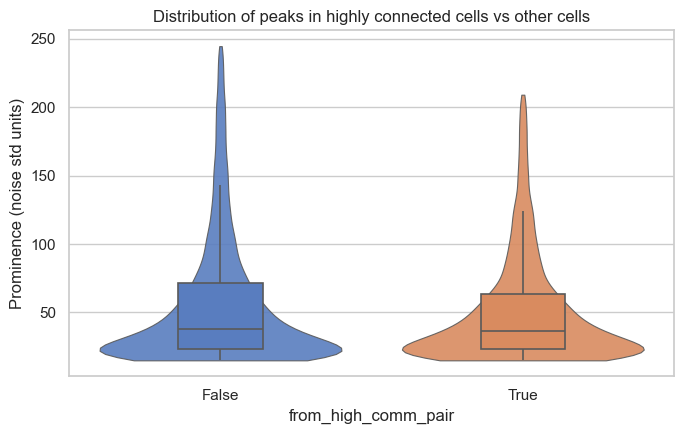

[2025-08-16 17:54:53] [INFO] calcium: plot_violin: removed 606 outliers out of 17179 on 'Speed (um/s)' (lower=-18.33, upper=27.87)


c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:954: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(**violin_kwargs)
c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:984: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp_ax = sns.boxplot(


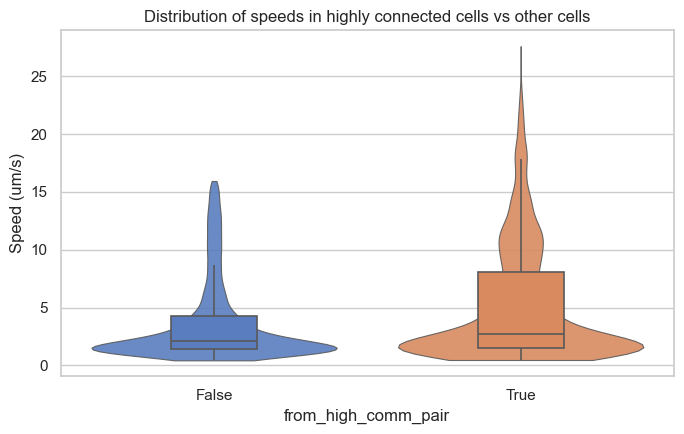

In [25]:
plot_violin(
    df=control_peaks[control_peaks["In event"] == "sequential"],
    x="from_high_comm_pair",
    y="Duration (s)",
    title="Distribution of peaks in highly connected cells vs other cells",
    filter_outliers=True,
    outliers_bounds=(3, 3),
    outliers_bygroup="from_high_comm_pair"
)

plot_violin(
    df=control_peaks[control_peaks["In event"] == "sequential"],
    x="from_high_comm_pair",
    y="Prominence (noise std units)",
    title="Distribution of peaks in highly connected cells vs other cells",
    filter_outliers=True,
    outliers_bounds=(3, 3),
    outliers_bygroup="from_high_comm_pair"
)

plot_violin(
    df=control_communications,
    x="from_high_comm_pair",
    y="Speed (um/s)",
    title="Distribution of speeds in highly connected cells vs other cells",
    filter_outliers=True,
    outliers_bounds=(3, 3),
    outliers_bygroup="from_high_comm_pair"
)

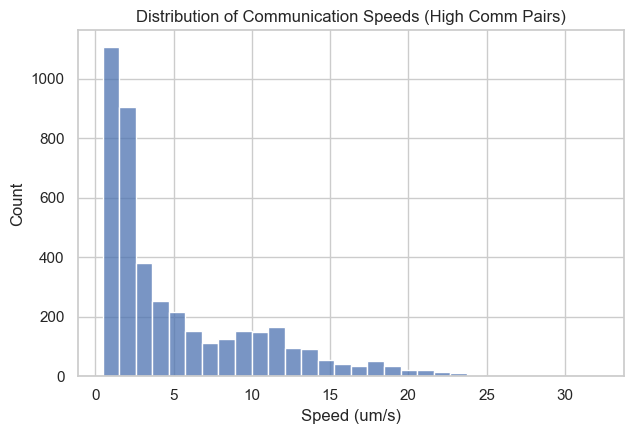

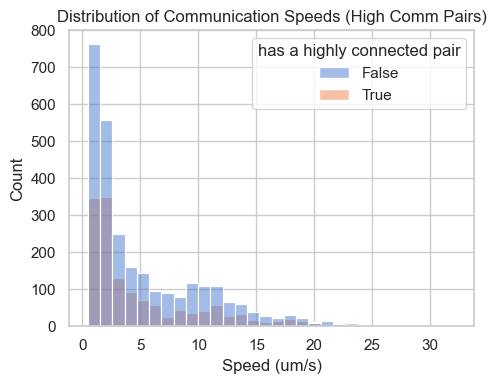

In [26]:
plot_histogram(
    df=control_communications[control_communications["from_high_comm_pair"]],
    column="Speed (um/s)",
    title="Distribution of Communication Speeds (High Comm Pairs)",
)


hc_true = highly_connected_cells[highly_connected_cells["Highly connected pairs"]]
hc_index = pd.MultiIndex.from_frame(hc_true[["dataset", "Cell ID"]])

idx_origin = pd.MultiIndex.from_frame(control_communications[["dataset", "Origin cell ID"]])
idx_cause  = pd.MultiIndex.from_frame(control_communications[["dataset", "Cause cell ID"]])

control_communications["has a highly connected pair"] = (
    idx_origin.isin(hc_index) | idx_cause.isin(hc_index)
)

plot_histogram_by_group(
    df=control_communications[control_communications["from_high_comm_pair"]],
    value_column="Speed (um/s)",
    group_column="has a highly connected pair",
    title="Distribution of Communication Speeds (High Comm Pairs)",
    multiple="layer"
)

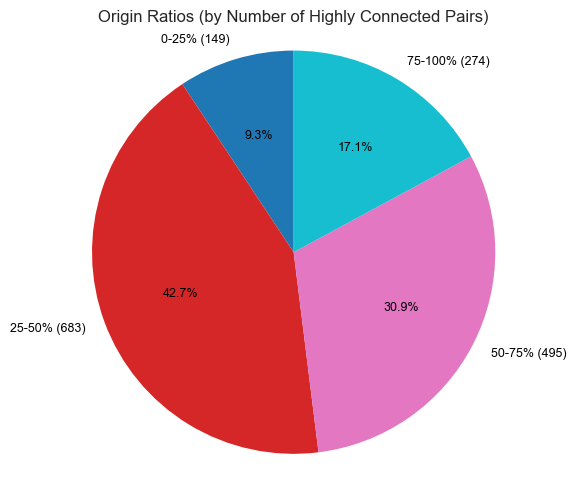

In [27]:
highly_connected_cells["Origin ratio category"] = pd.cut(
    highly_connected_cells["Origin ratio (origin/communications)"],
    bins=[0, 0.25, 0.5, 0.75, 1],
    labels=["0-25%", "25-50%", "50-75%", "75-100%"]
)

plot_pie_chart(
    df=highly_connected_cells,
    column="Origin ratio category",
    title="Origin Ratios (by Number of Highly Connected Pairs)"
)



## INDIVIDUAL EVENTS

In [28]:
individual_peaks = control_peaks[control_peaks["In event"] == "individual"].copy()

### Mapping of cell occurences in individual events

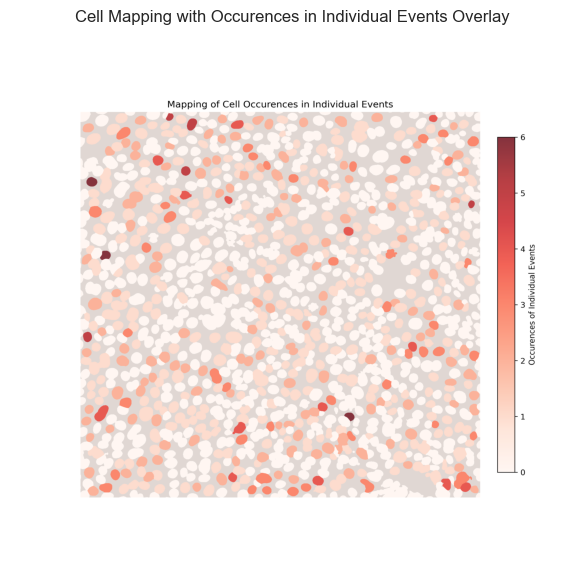

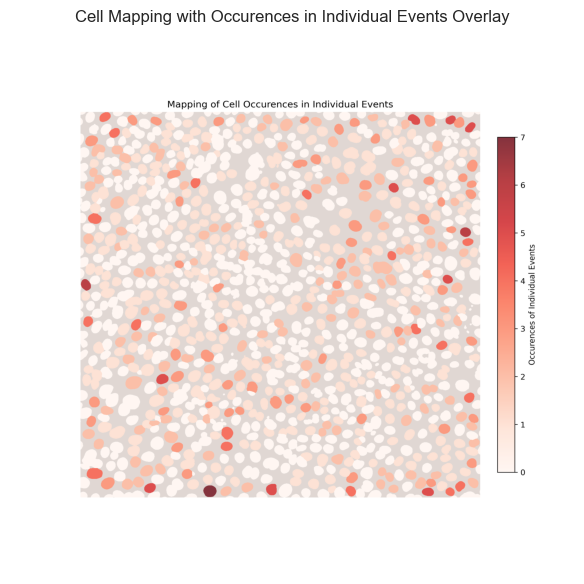

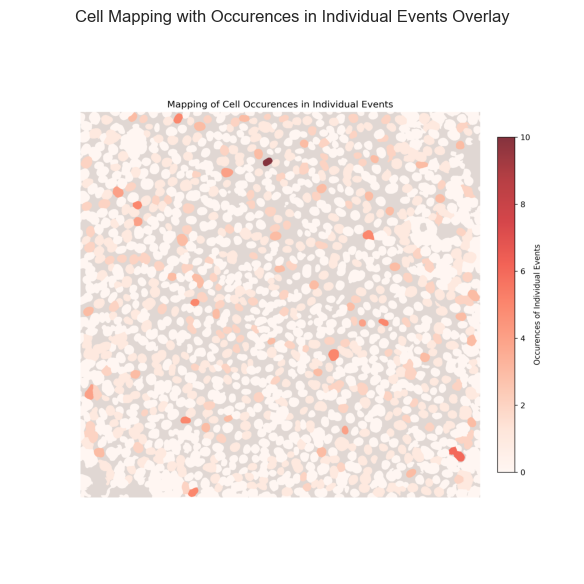

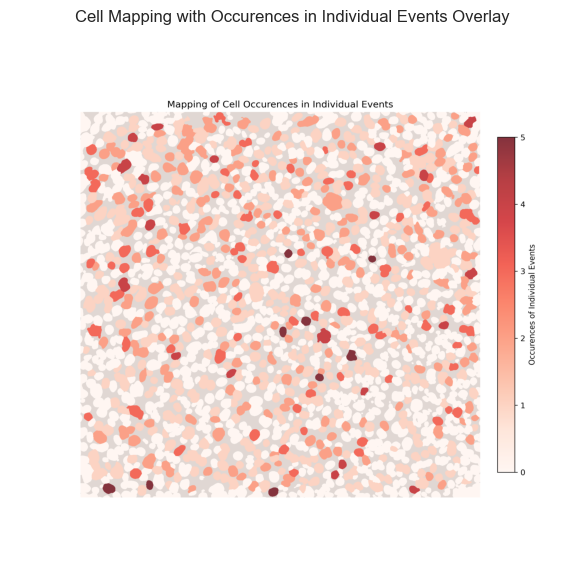

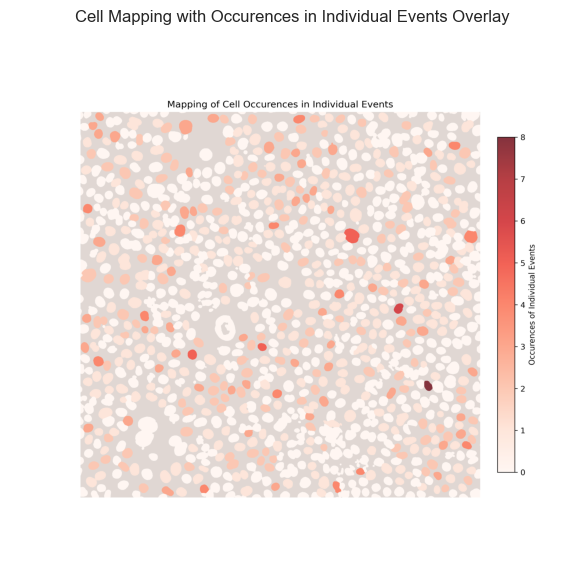

In [29]:

for (date, image_sequence), df_subset in individual_peaks.groupby(["date", "image_sequence"]):
    visualize_image(
        image_source={f"{date} - {image_sequence}": f"D:/Mateo/{date}/Output/{image_sequence}"},
        image_name="cell-mapping/cell_occurences_in_individual_events_overlay.png",
        title="Cell Mapping with Occurences in Individual Events Overlay",
        figsize=(6, 6)
    )

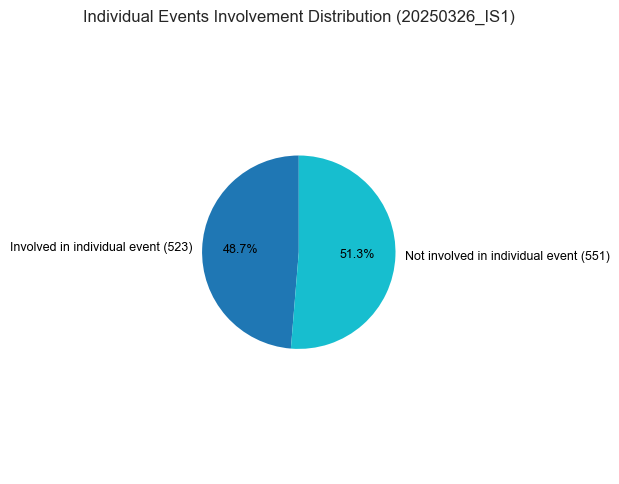

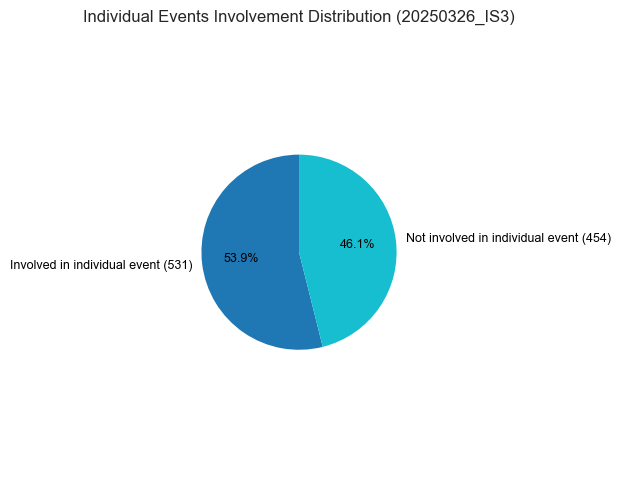

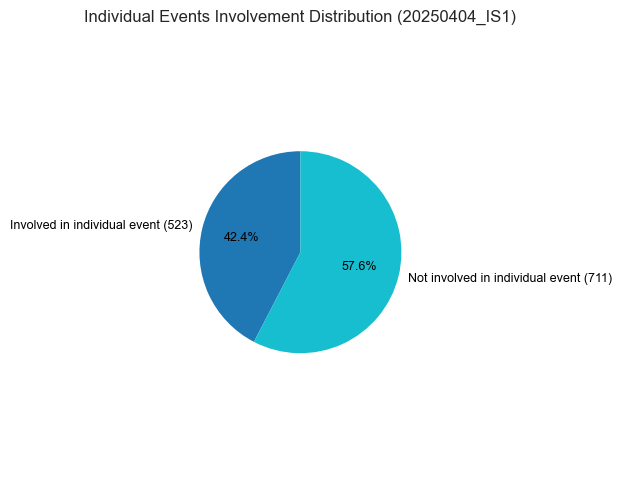

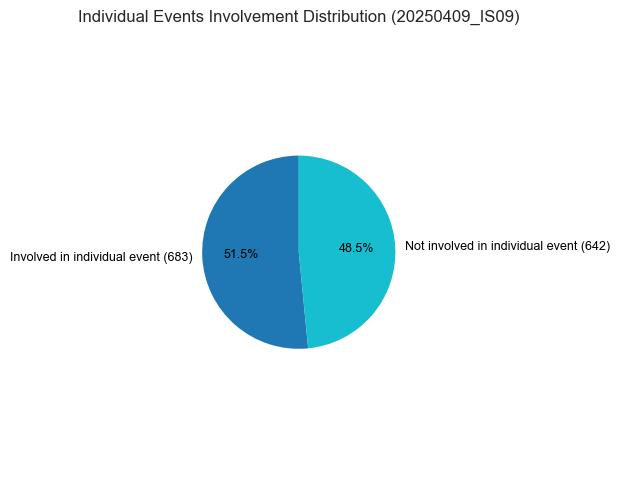

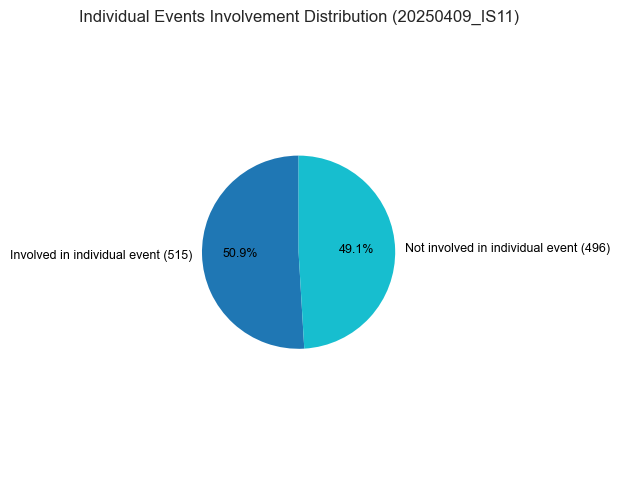

In [30]:
control_cells["Involved in individual event"] = control_cells["Occurences in individual events"].apply(lambda x: "Involved in individual event" if x > 0 else "Not involved in individual event")

for dataset_name, subset in control_cells.groupby("dataset"):
    plot_pie_chart(
        df=subset,
        column="Involved in individual event",
        title=f"Individual Events Involvement Distribution ({dataset_name})"
    )


### Peak features repeatability

[2025-08-16 17:55:01] [INFO] calcium: plot_violin: removed 92 outliers out of 4457 on 'Duration (s)' (lower=-36, upper=86)


c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:954: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(**violin_kwargs)
c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:984: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp_ax = sns.boxplot(


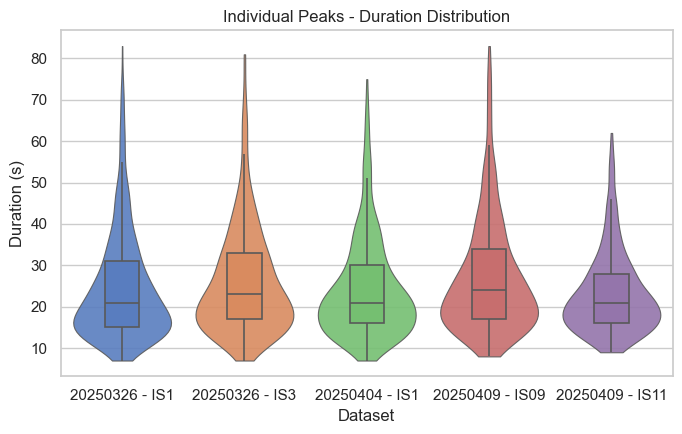

[2025-08-16 17:55:01] [INFO] calcium: plot_violin: removed 214 outliers out of 4457 on 'Prominence (noise std units)' (lower=-130.28, upper=219.9)


c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:954: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(**violin_kwargs)
c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:984: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp_ax = sns.boxplot(


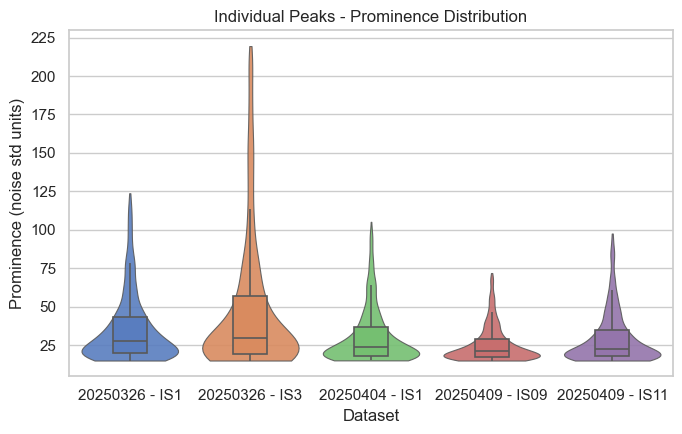

In [31]:
control_peaks["dataset name"] = control_peaks['date'].astype(str) + " - " + control_peaks['image_sequence'].astype(str)

plot_violin(
    df=individual_peaks,
    x="dataset name",
    y="Duration (s)",
    title="Individual Peaks - Duration Distribution",
    ylabel="Duration (s)",
    xlabel="Dataset",
    width=0.8,
    filter_outliers=True,
    outliers_bounds=(3, 3),
    dodge=False,
    outliers_bygroup="dataset name"
)
plot_violin(
    df=individual_peaks,
    x="dataset name",
    y="Prominence (noise std units)",
    title="Individual Peaks - Prominence Distribution",
    ylabel="Prominence (noise std units)",
    xlabel="Dataset",
    width=0.8,
    filter_outliers=True,
    outliers_bounds=(3, 3),
    dodge=False,
    outliers_bygroup="dataset name"
)

c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:1243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(


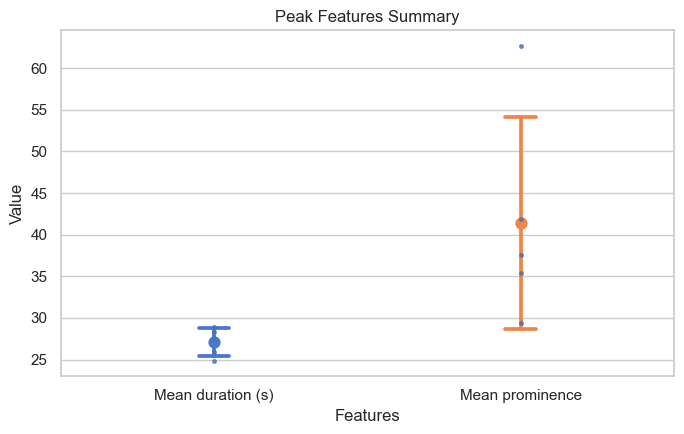

In [32]:
peak_features_summary_list = []

for dataset_name, df_subset in individual_peaks.groupby("dataset name"):
    peak_features_summary_list.append({
        "dataset name": dataset_name,
        "Value type": "Mean duration (s)",
        "Value": df_subset["Duration (s)"].mean()
    })
    peak_features_summary_list.append({
        "dataset name": dataset_name,
        "Value type": "Mean prominence",
        "Value": df_subset["Prominence (noise std units)"].mean()
    })

peak_features_summary_df = pd.DataFrame(peak_features_summary_list)

plot_points_mean_std(
    df=peak_features_summary_df,
    x="Value type",
    y="Value",
    title="Peak Features Summary",
    ylabel="Value",
    xlabel="Features"
)

## INTER EVENT ANALYSIS

[2025-08-16 17:55:02] [INFO] calcium: plot_points_mean_std: removed 6 outliers out of 1074 on 'Occurences in sequential events' (lower=-2, upper=12)


c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:1243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(


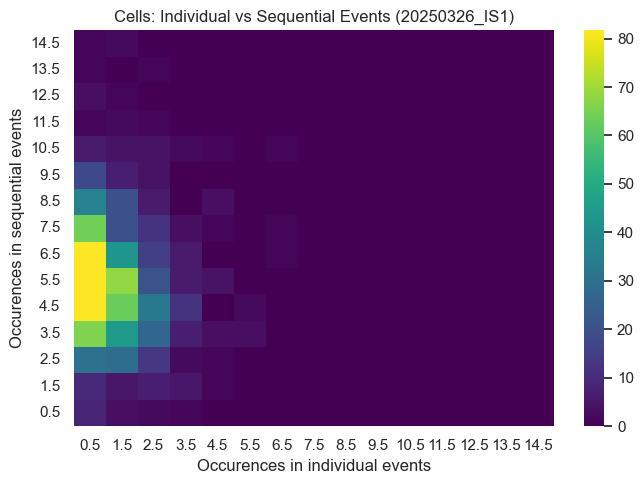

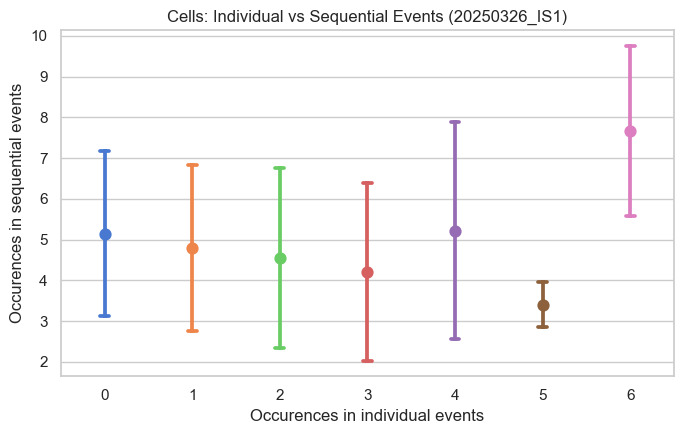

[2025-08-16 17:55:02] [INFO] calcium: plot_points_mean_std: removed 0 outliers out of 985 on 'Occurences in sequential events' (lower=-4, upper=17)


c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:1243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(


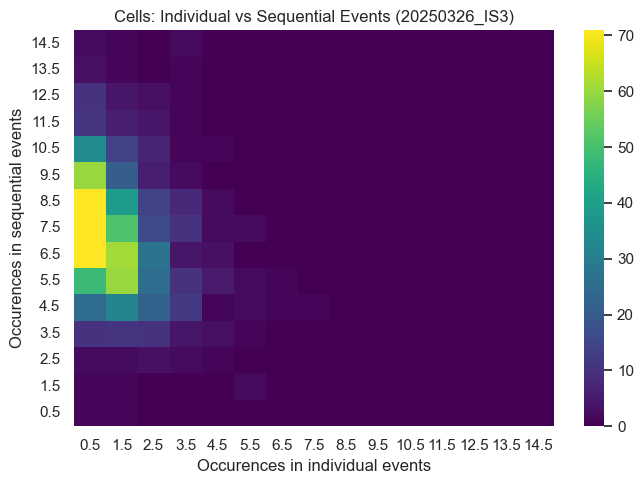

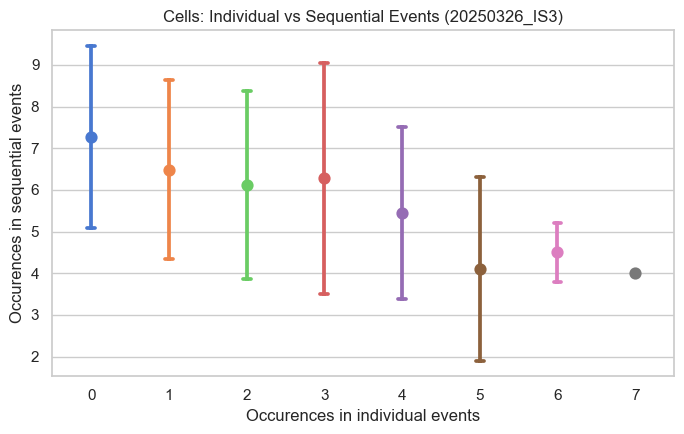

[2025-08-16 17:55:03] [INFO] calcium: plot_points_mean_std: removed 1 outliers out of 1234 on 'Occurences in sequential events' (lower=-4, upper=10)


c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:1243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(


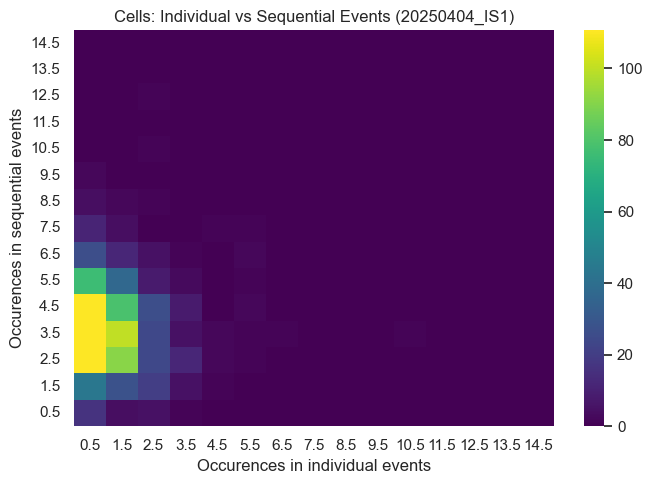

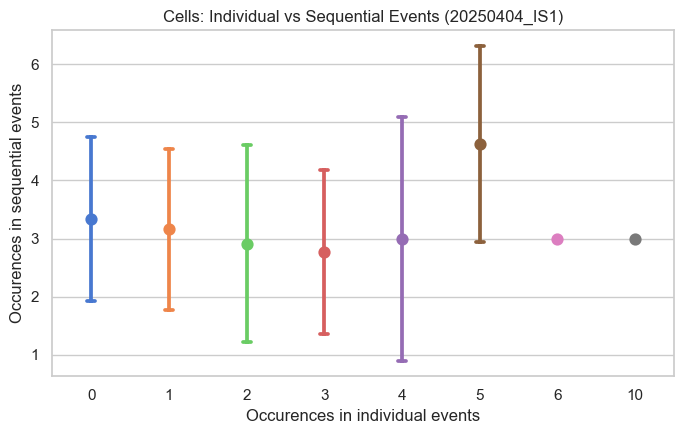

[2025-08-16 17:55:03] [INFO] calcium: plot_points_mean_std: removed 1 outliers out of 1325 on 'Occurences in sequential events' (lower=-4, upper=10)


c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:1243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(


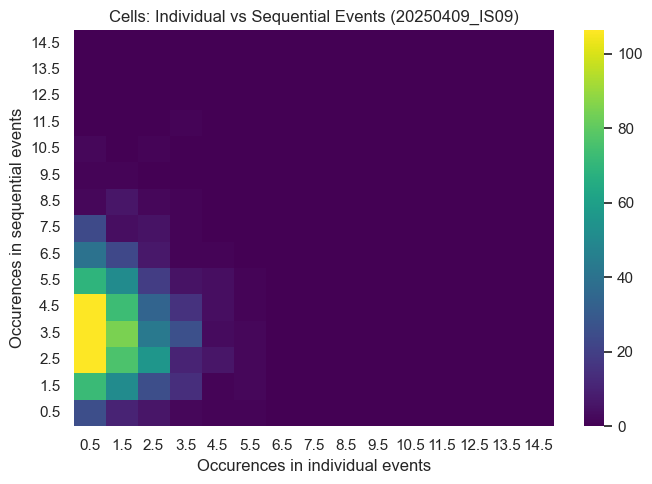

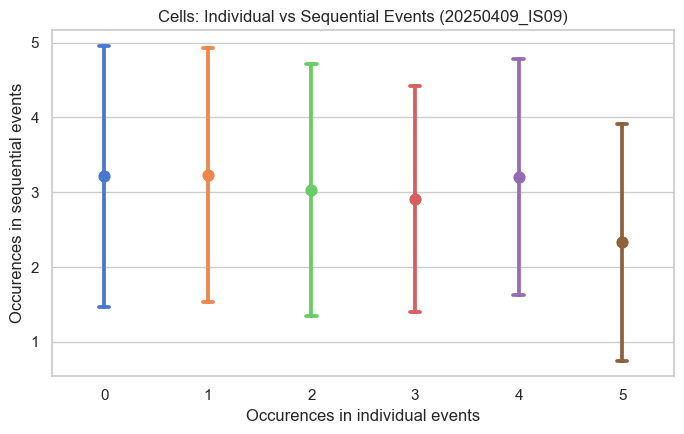

[2025-08-16 17:55:03] [INFO] calcium: plot_points_mean_std: removed 2 outliers out of 1011 on 'Occurences in sequential events' (lower=-6, upper=8)


c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:1243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(


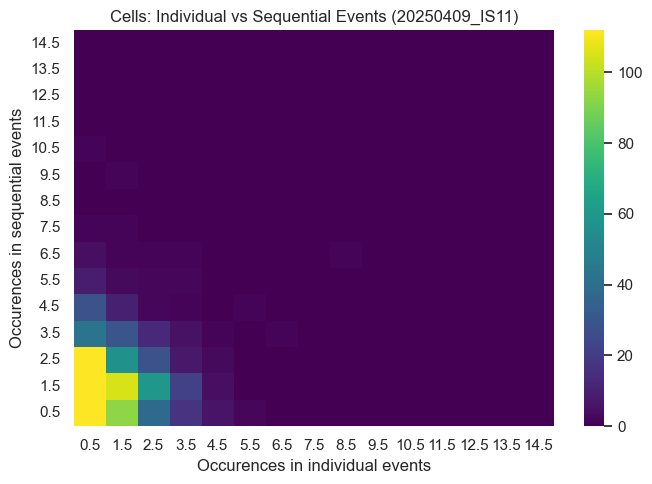

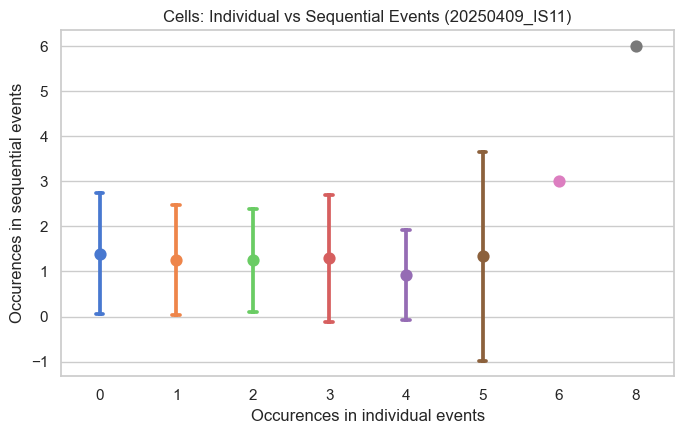

In [33]:
for dataset_name, df_subset in control_cells.groupby("dataset"):
    plot_heatmap(
        df=df_subset,
        x="Occurences in individual events",
        y="Occurences in sequential events",
        title=f"Cells: Individual vs Sequential Events ({dataset_name})",
        bins_x=15,
        bins_y=15,
        range_x=(0,15),
        range_y=(0,15),
        stat="count",
        clip_quantiles=(0.01, 0.99),
    )

    plot_points_mean_std(
        df=df_subset,
        x="Occurences in individual events",
        y="Occurences in sequential events",
        title=f"Cells: Individual vs Sequential Events ({dataset_name})",
        show_points=False,
        filter_outliers=True,
        outliers_bounds=(3, 3),
    )

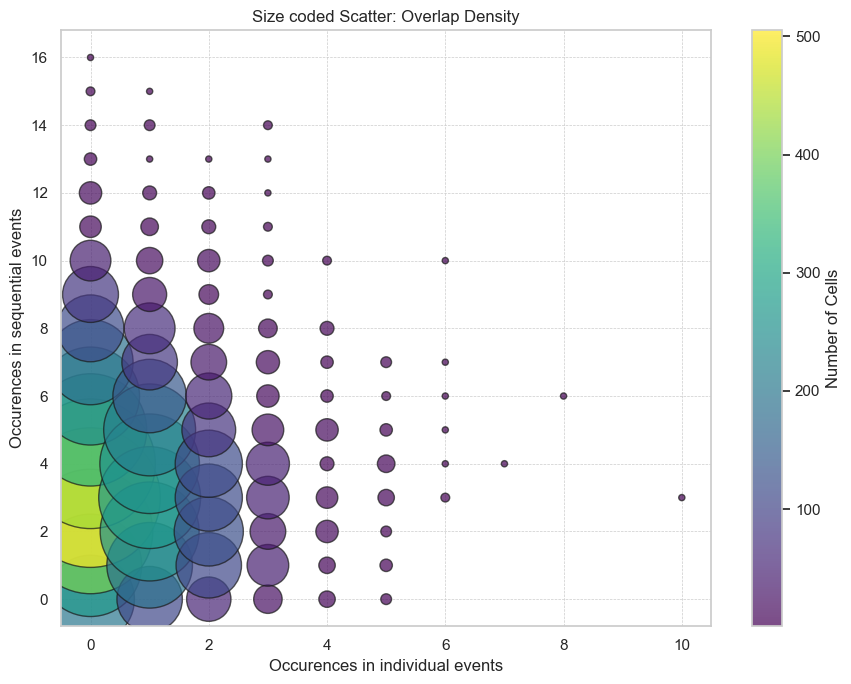

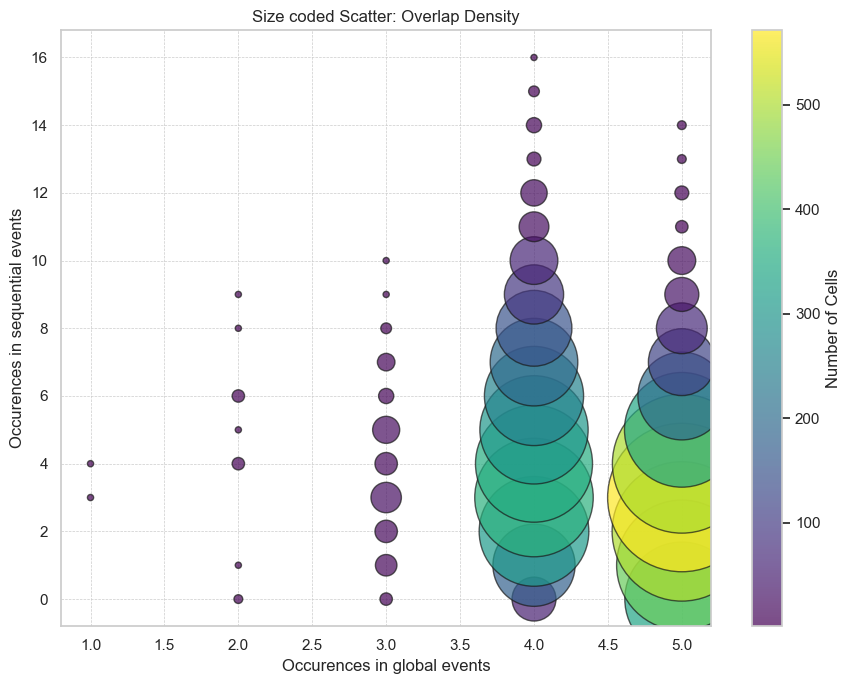

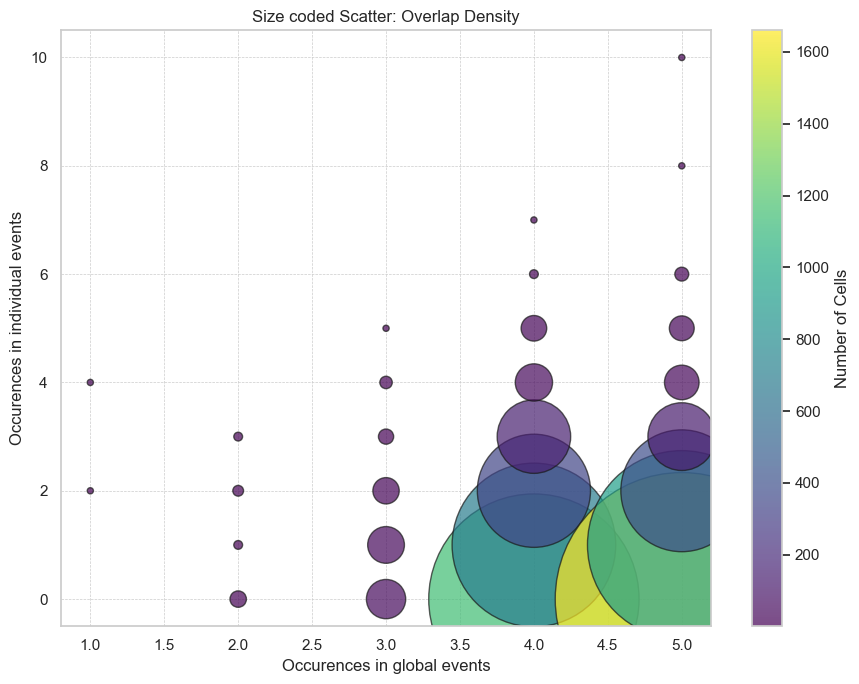

In [34]:
plot_scatter_size_coded(
    df=control_cells,
    x_col="Occurences in individual events",
    y_col="Occurences in sequential events",
    size_scale=20,
    figsize=(9, 7)
)
plot_scatter_size_coded(
    df=control_cells,
    x_col="Occurences in global events",
    y_col="Occurences in sequential events",
    size_scale=20,
    figsize=(9, 7)
)
plot_scatter_size_coded(
    df=control_cells,
    x_col="Occurences in global events",
    y_col="Occurences in individual events",
    size_scale=20,
    figsize=(9, 7)
)

c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:1243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(


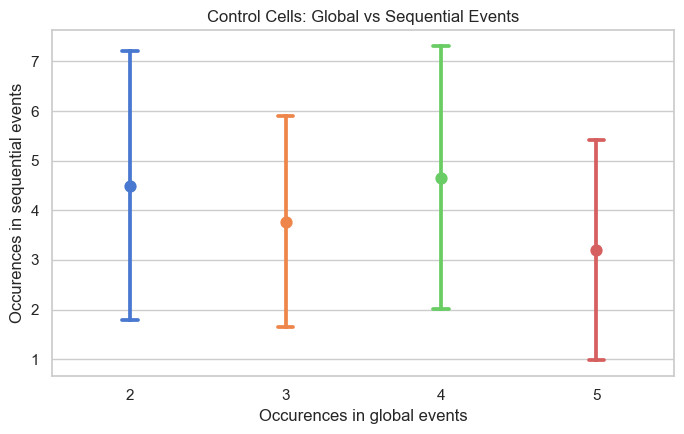

c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:1243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(


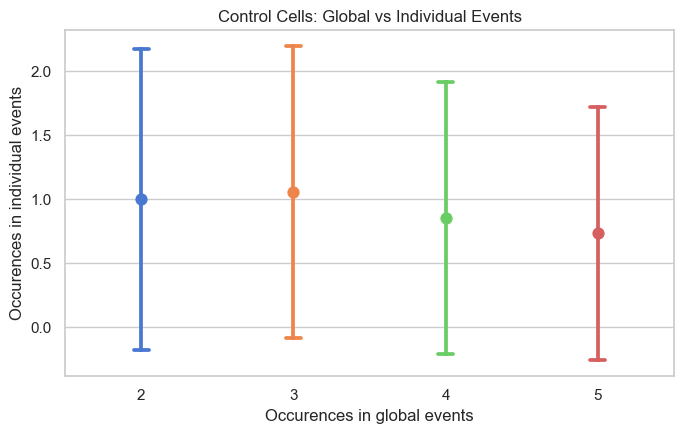

c:\Users\poseidon\OneDrive\Documents\01_ETHZ\Master_Degree\Spring_Semester_2025\Master_Thesis\Coding\Image_analysis\src\calcium_activity_characterization\analysis\visualizers.py:1243: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(


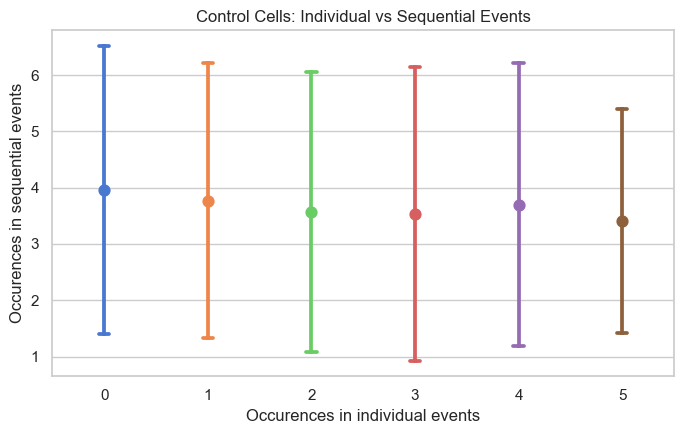

In [35]:
counts = control_cells["Occurences in global events"].value_counts()
keep_values = counts[counts > 10].index
valid_cells = control_cells[control_cells["Occurences in global events"].isin(keep_values)]

plot_points_mean_std(
    df=valid_cells,
    x="Occurences in global events",
    y="Occurences in sequential events",
    title="Control Cells: Global vs Sequential Events",
    show_points=False
)

plot_points_mean_std(
    df=valid_cells,
    x="Occurences in global events",
    y="Occurences in individual events",
    title="Control Cells: Global vs Individual Events",
    show_points=False
)

counts = control_cells["Occurences in individual events"].value_counts()
keep_values = counts[counts > 10].index
valid_cells = control_cells[control_cells["Occurences in individual events"].isin(keep_values)]

plot_points_mean_std(
    df=valid_cells,
    x="Occurences in individual events",
    y="Occurences in sequential events",
    title="Control Cells: Individual vs Sequential Events",
    show_points=False
)

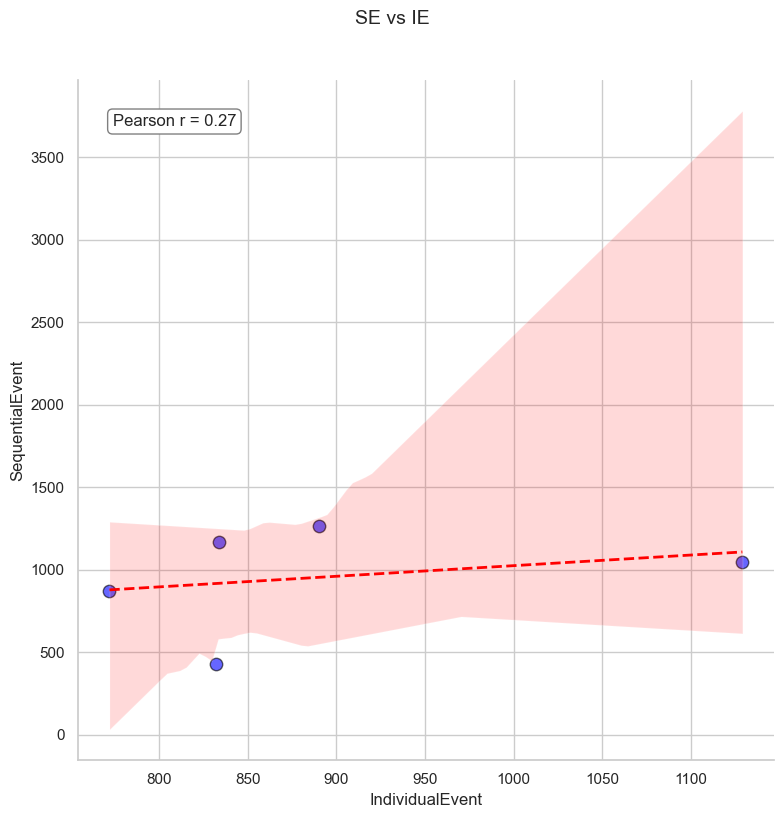

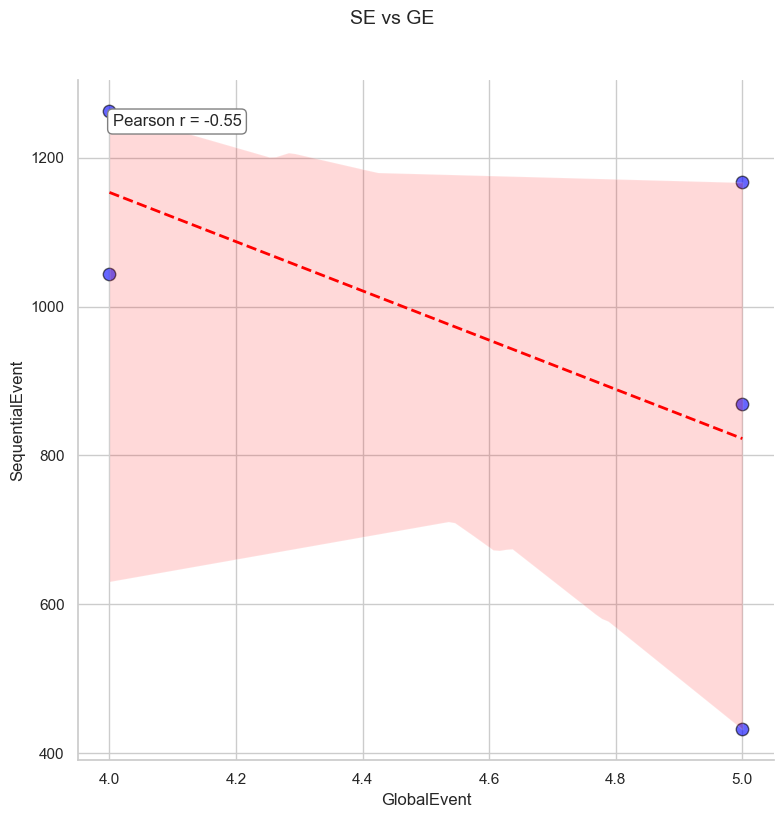

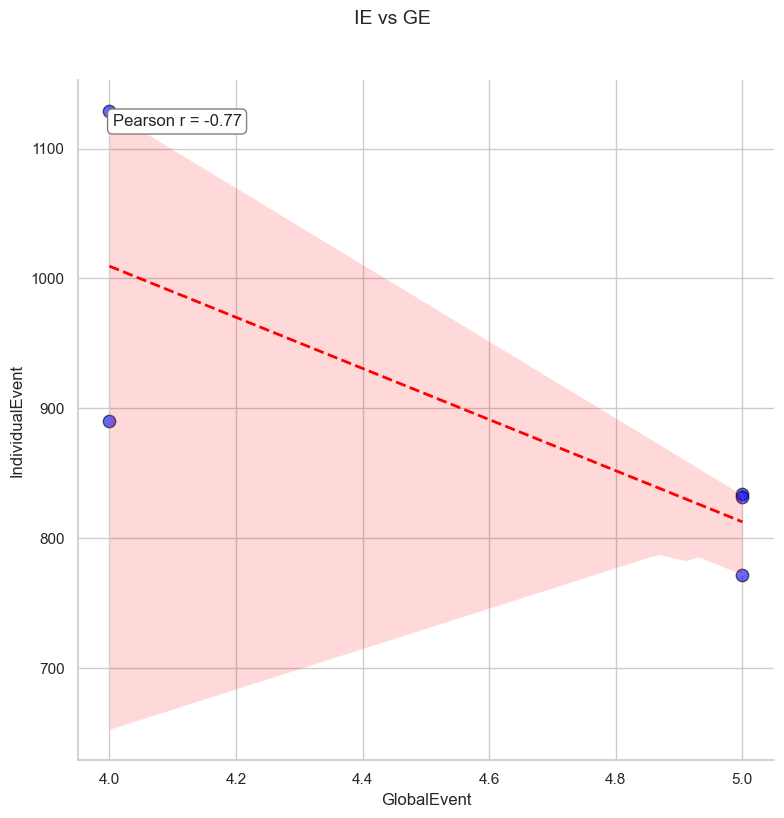

In [36]:
plot_xy_with_regression(
    data=control_experiments,
    y_col="SequentialEvent",
    x_col="IndividualEvent",
    corr_method="pearson",
    title="SE vs IE"
)

plot_xy_with_regression(
    data=control_experiments,
    y_col="SequentialEvent",
    x_col="GlobalEvent",
    corr_method="pearson",
    title="SE vs GE"
)

plot_xy_with_regression(
    data=control_experiments,
    y_col="IndividualEvent",
    x_col="GlobalEvent",
    corr_method="pearson",
    title="IE vs GE"
)